In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import mne
import json
import scipy.stats
import copy
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold
import random
from scipy.stats import ttest_ind
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
import random
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from scipy.stats import mode
import matplotlib

In [2]:
montage = mne.channels.read_dig_fif('montage.fif')
montage.ch_names = json.load(open("montage_ch_names.json"))
montage.dig = montage.dig[:64]
montage.ch_names = montage.ch_names[:64]
for i in range(len(montage.dig)):
    montage.dig[i]['r'] = np.array([item * 1e-6 for item in montage.dig[i]['r']])
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
for dig_info_ in ten_twenty_montage.dig:
    dig_info = copy.deepcopy(dig_info_)
    if 'EEG' not in str(dig_info['kind']):
        montage.dig.insert(0, dig_info)
picked_channels = ["FP1", "FPZ", "FP2", "AF3", "AF4", "F7", "F5", "F3", "F1", "FZ", "F2", "F4", "F6", "F8", "FT7", "FC5", "FC3", "FC1", "FCZ", "FC2", "FC4", "FC6", "FT8", "T7", "C5", "C3", "C1", "CZ", "C2", "C4", "C6", "T8", "TP7", "CP5", "CP3", "CP1", "CPZ", "CP2", "CP4", "CP6", "TP8", "P7", "P5", "P3", "P1", "PZ", "P2", "P4", "P6", "P8", "PO7", "PO5", "PO3", "POZ", "PO4", "PO6", "PO8", "O1", "OZ", "O2", ]
total_channels = ["FP1", "FPZ", "FP2", "AF3", "AF4", "F7", "F5", "F3", "F1", "FZ", "F2", "F4", "F6", "F8", "FT7", "FC5", "FC3", "FC1", "FCZ", "FC2", "FC4", "FC6", "FT8", "T7", "C5", "C3", "C1", "CZ", "C2", "C4", "C6", "T8", "TP7", "CP5", "CP3", "CP1", "CPZ", "CP2", "CP4", "CP6", "TP8", "P7", "P5", "P3", "P1", "PZ", "P2", "P4", "P6", "P8", "PO7", "PO5", "PO3", "POZ", "PO4", "PO6", "PO8", "CB1", "O1", "OZ", "O2", "CB2", ]
fake_info = mne.create_info(ch_names=total_channels, sfreq=1000., ch_types='eeg')
select_index = [idx for idx in range(len(total_channels)) if total_channels[idx] in picked_channels]
# 设置全局字体为Arial
matplotlib.rcParams['font.family'] = 'Arial'

In [3]:
dates=['fanhao', 'dongyimeng', 'houlinzhi', 'jiwenjun',  'miaoshengze','wanfangwei','wangxiaoting', 'wangzhengni', 'yangchen', 'huqifan',
       'zhangxue','liangqihang', 'daisiwei', 'zhangyutong', 'mengfanjie', 'zhangchenxi', 'liangyanshu','cangyueyang', 'hongyurui','lujianing',
       'zhaochensong','chenxingyu','chenrong'
       ]
# Preload JSON data
v2info_LAB1_data = {}
v2info_LAB2_data = {}
for date in dates:
    v2info_LAB1_data[date] = json.load(open(f'./v2info/LAB1-{date}_v2info.json'))
    v2info_LAB2_data[date] = json.load(open(f'./v2info/LAB2-{date}_v2info.json'))
#得到每个被试time、like标准化的核
time_core={}
like_core={}
for date in dates:
    this_core_time=[]
    this_core_like=[]
    for v,info in v2info_LAB1_data[date].items():
       if(info['video_type']<6):
            this_core_time.append(info['play_duration'])
            this_core_like.append(info['like'])
    core_std_time=np.std(this_core_time)
    core_mean_time=np.mean(this_core_time)
    core_std_like=np.std(this_core_like)
    core_mean_like=np.mean(this_core_like)
    time_core[date]=(core_mean_time,core_std_time)
    like_core[date]=(core_mean_like,core_std_like)


In [4]:
#正向/负向环境作用前后，观看正面视频的时长
time_povideo_before_positive=[]
time_povideo_after_positive=[]
time_povideo_before_negative=[]
time_povideo_after_negative=[]
for date in dates:
    for v,info in v2info_LAB1_data[date].items():
        if(info['video_type']==0):
            if(info['tend']==0):
                time_povideo_before_positive.append(info['play_duration'])
            if(info['tend']==1):
                time_povideo_before_negative.append(info['play_duration'])
    for v,info in v2info_LAB2_data[date].items():
        if(info['video_type']==0):
            if(info['tend']==0):
                time_povideo_after_positive.append(info['play_duration'])
            if(info['tend']==1):
                time_povideo_after_negative.append(info['play_duration'])
print("正向环境作用前，观看正面视频的平均时长：",np.mean(time_povideo_before_positive))
print("正向环境作用后，观看正面视频的平均时长：",np.mean(time_povideo_after_positive))
print("负向环境作用前，观看正面视频的平均时长：",np.mean(time_povideo_before_negative))
print("负向环境作用后，观看正面视频的平均时长：",np.mean(time_povideo_after_negative))        

正向环境作用前，观看正面视频的平均时长： 0.7879084967320262
正向环境作用后，观看正面视频的平均时长： 0.759640522875817
负向环境作用前，观看正面视频的平均时长： 0.8026041666666667
负向环境作用后，观看正面视频的平均时长： 0.8067708333333334


In [5]:
#标准化！
#正向/负向环境作用前后，观看正面视频的时长
time_povideo_before_positive=[]
time_povideo_after_positive=[]
time_povideo_before_negative=[]
time_povideo_after_negative=[]
for date in dates:
    time_mean,time_std=time_core[date]
    for v,info in v2info_LAB1_data[date].items():
        if(info['video_type']==0):
            if(info['tend']==0):
                time_povideo_before_positive.append((info['play_duration']-time_mean)/time_std)
            if(info['tend']==1):
                time_povideo_before_negative.append((info['play_duration']-time_mean)/time_std)
    for v,info in v2info_LAB2_data[date].items():
        if(info['video_type']==0):
            if(info['tend']==0):
                time_povideo_after_positive.append((info['play_duration']-time_mean)/time_std)
            if(info['tend']==1):
                time_povideo_after_negative.append((info['play_duration']-time_mean)/time_std)
    

print("正向环境作用前，观看正面视频的平均时长：",np.mean(time_povideo_before_positive))
print("正向环境作用后，观看正面视频的平均时长：",np.mean(time_povideo_after_positive))
print("负向环境作用前，观看正面视频的平均时长：",np.mean(time_povideo_before_negative))
print("负向环境作用后，观看正面视频的平均时长：",np.mean(time_povideo_after_negative))        

正向环境作用前，观看正面视频的平均时长： -0.05722120860094402
正向环境作用后，观看正面视频的平均时长： -0.20796085855704352
负向环境作用前，观看正面视频的平均时长： -0.16728298720246632
负向环境作用后，观看正面视频的平均时长： -0.05702804978513301


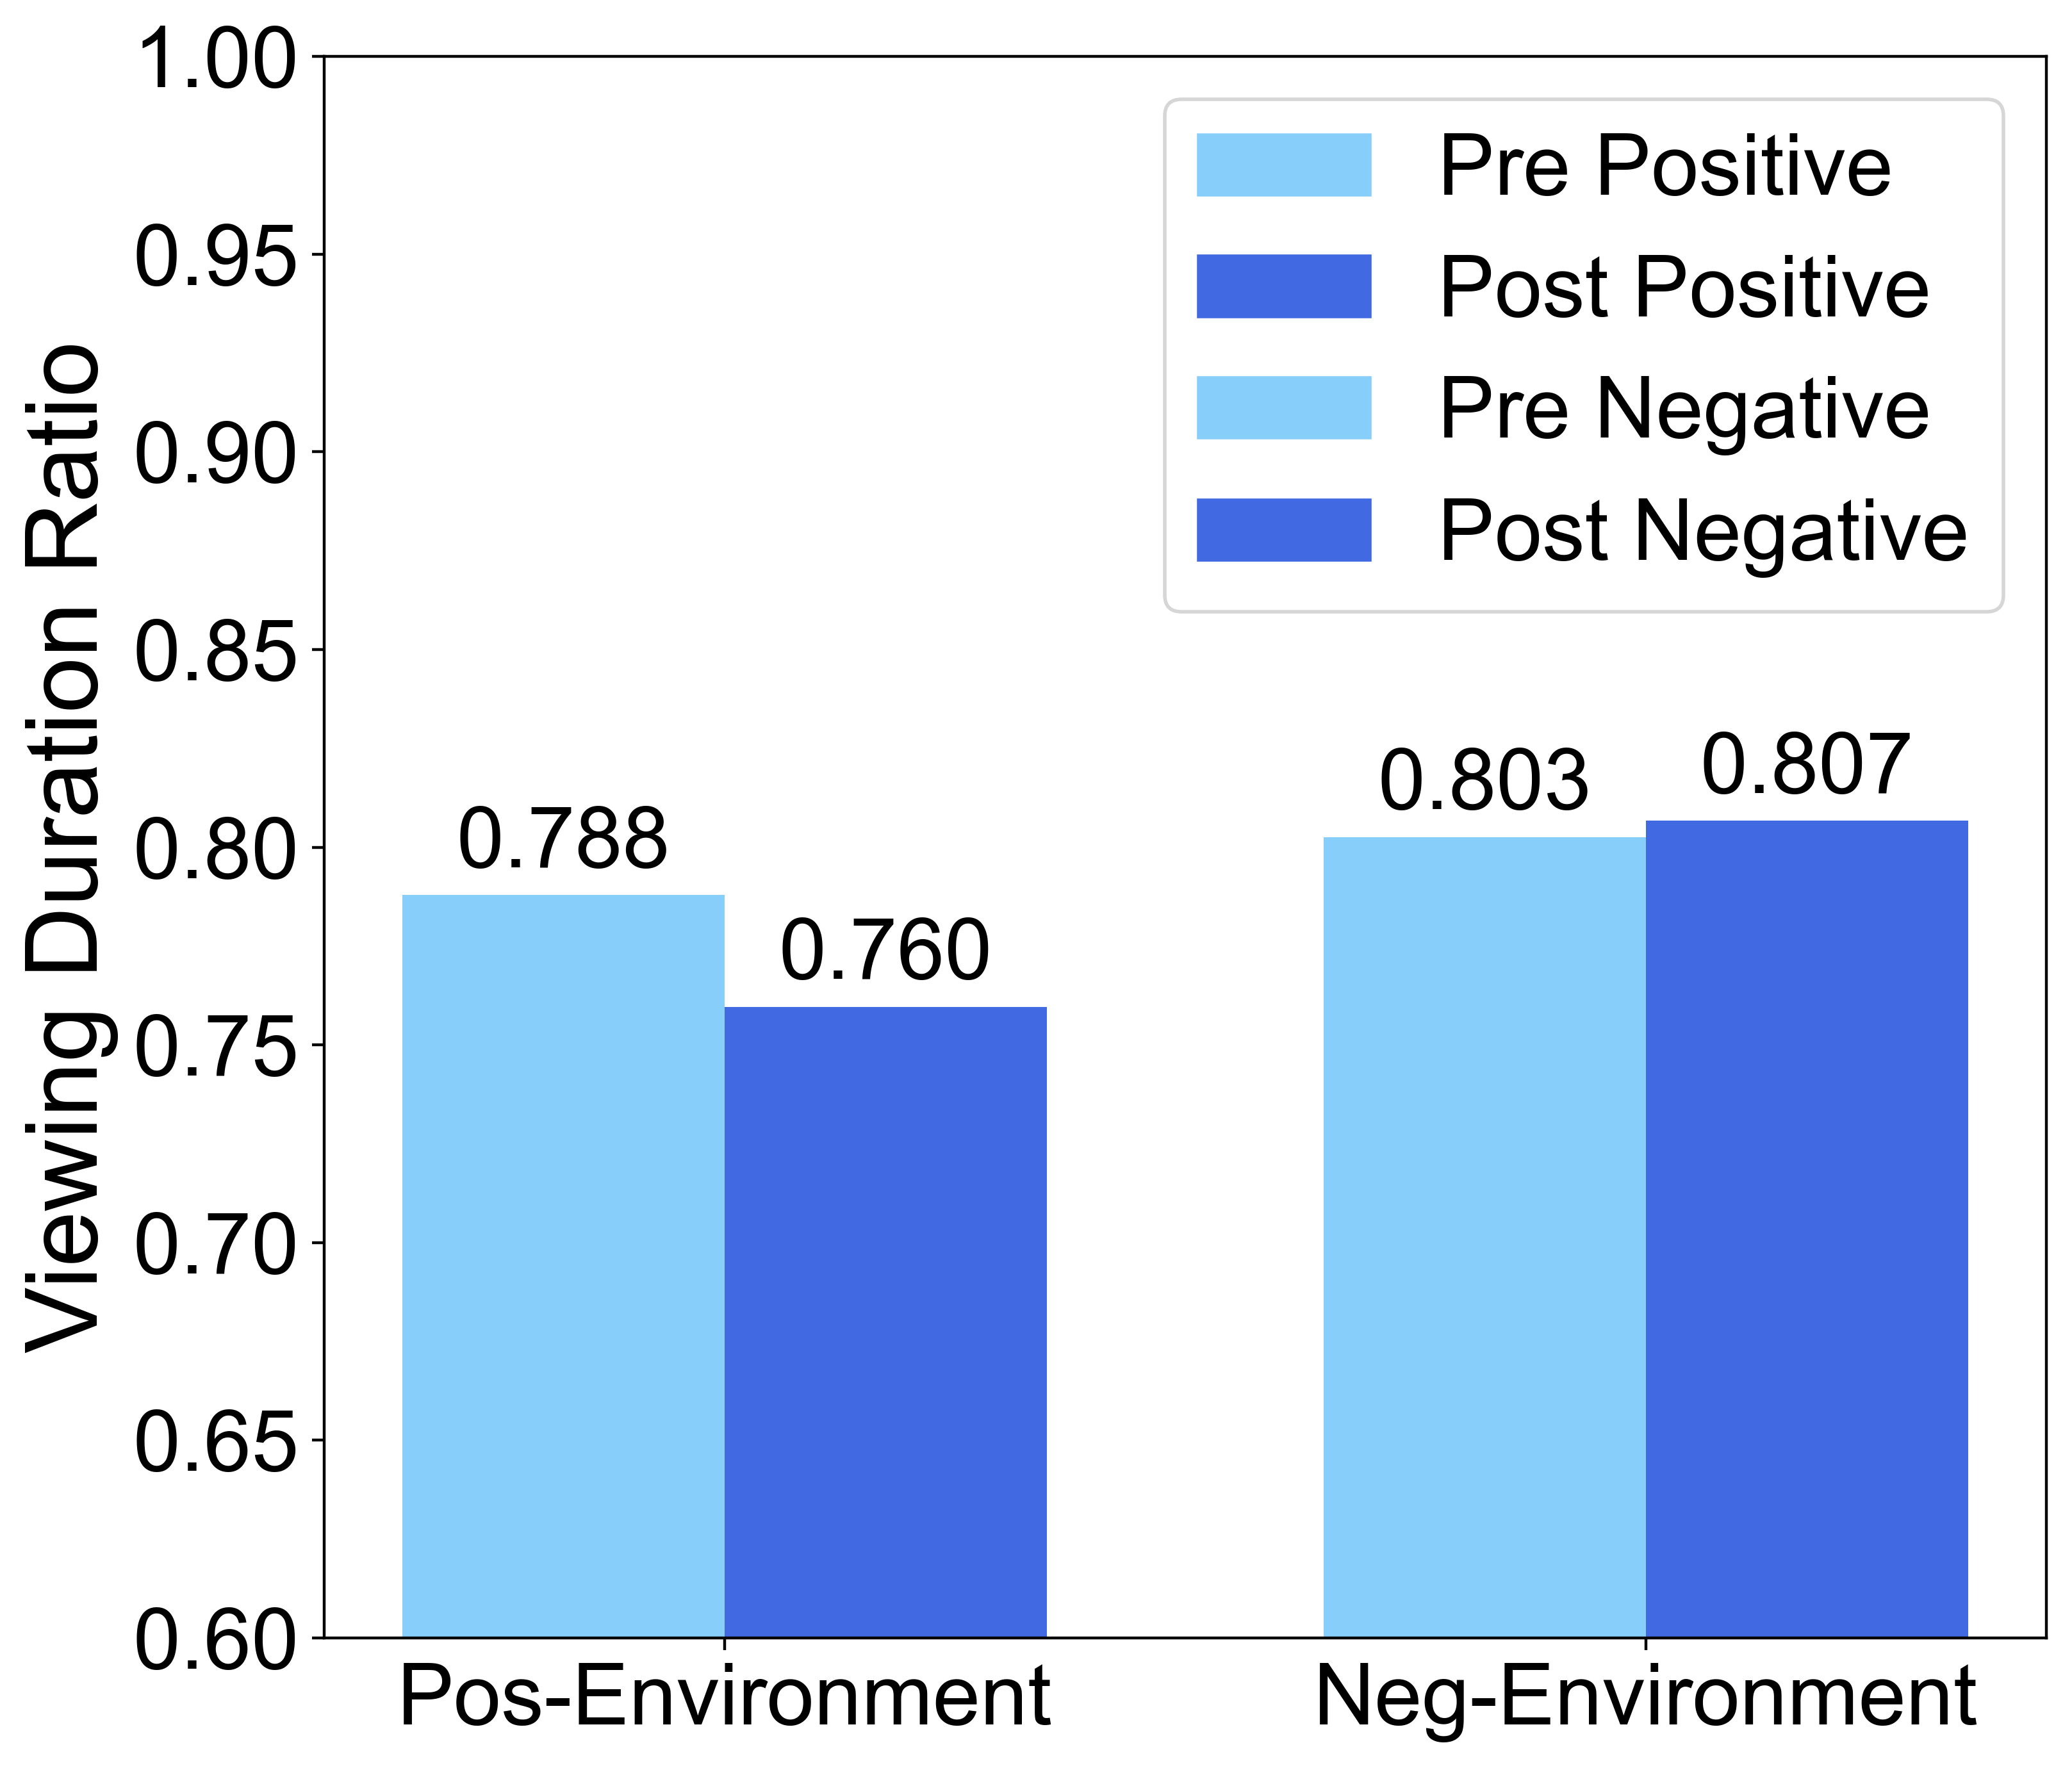

In [6]:
import matplotlib.patches as mpatches
# 新的数据
distractor_scores_new = (0.7879,0.7596,0.8026,0.8067)
# 创建图表，保持与之前相同的高度
fig, ax = plt.subplots(figsize=(8, 7), dpi=400)
# 设置标签和宽度
labels = ['Pos-Environment', 'Neg-Environment']
width = 0.35  # 柱状图的宽度
# 计算每组柱状图的位置
x = np.arange(len(labels))
x_distractor_before = x - width / 2
x_distractor_after = x + width / 2
# 定义颜色
colors_positive = ['lightskyblue', 'lightskyblue']
colors_negative = ['royalblue', 'royalblue']
# 绘制柱状图
rects1 = ax.bar(x_distractor_before, distractor_scores_new[::2], width, color=colors_positive)
rects2 = ax.bar(x_distractor_after, distractor_scores_new[1::2], width, color=colors_negative)
# 在每个柱状图上添加数值
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=24)
# 增加坐标轴数字的字体大小
ax.tick_params(axis='both', which='major', labelsize=24)    
# 添加标签、标题和自定义x轴刻度标签
ax.set_ylabel('Viewing Duration Ratio', fontsize=28)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=24)
# 设置y轴的起始点为3
ax.set_ylim([0.6, 1])
# 创建自定义图例
legend_elements = [mpatches.Patch(color='lightskyblue', label='Pre Positive'),
                   mpatches.Patch(color='royalblue', label='Post Positive'),
                   mpatches.Patch(color='lightskyblue', label='Pre Negative'),
                   mpatches.Patch(color='royalblue', label='Post Negative')]

# 将图例固定在右上角，并设置字体大小
ax.legend(handles=legend_elements, loc='upper right', fontsize=24)
# 调整布局
fig.tight_layout()
# 显示图表
plt.savefig('./final_pics/time_for_positive_videos.png', dpi=300)
plt.show()

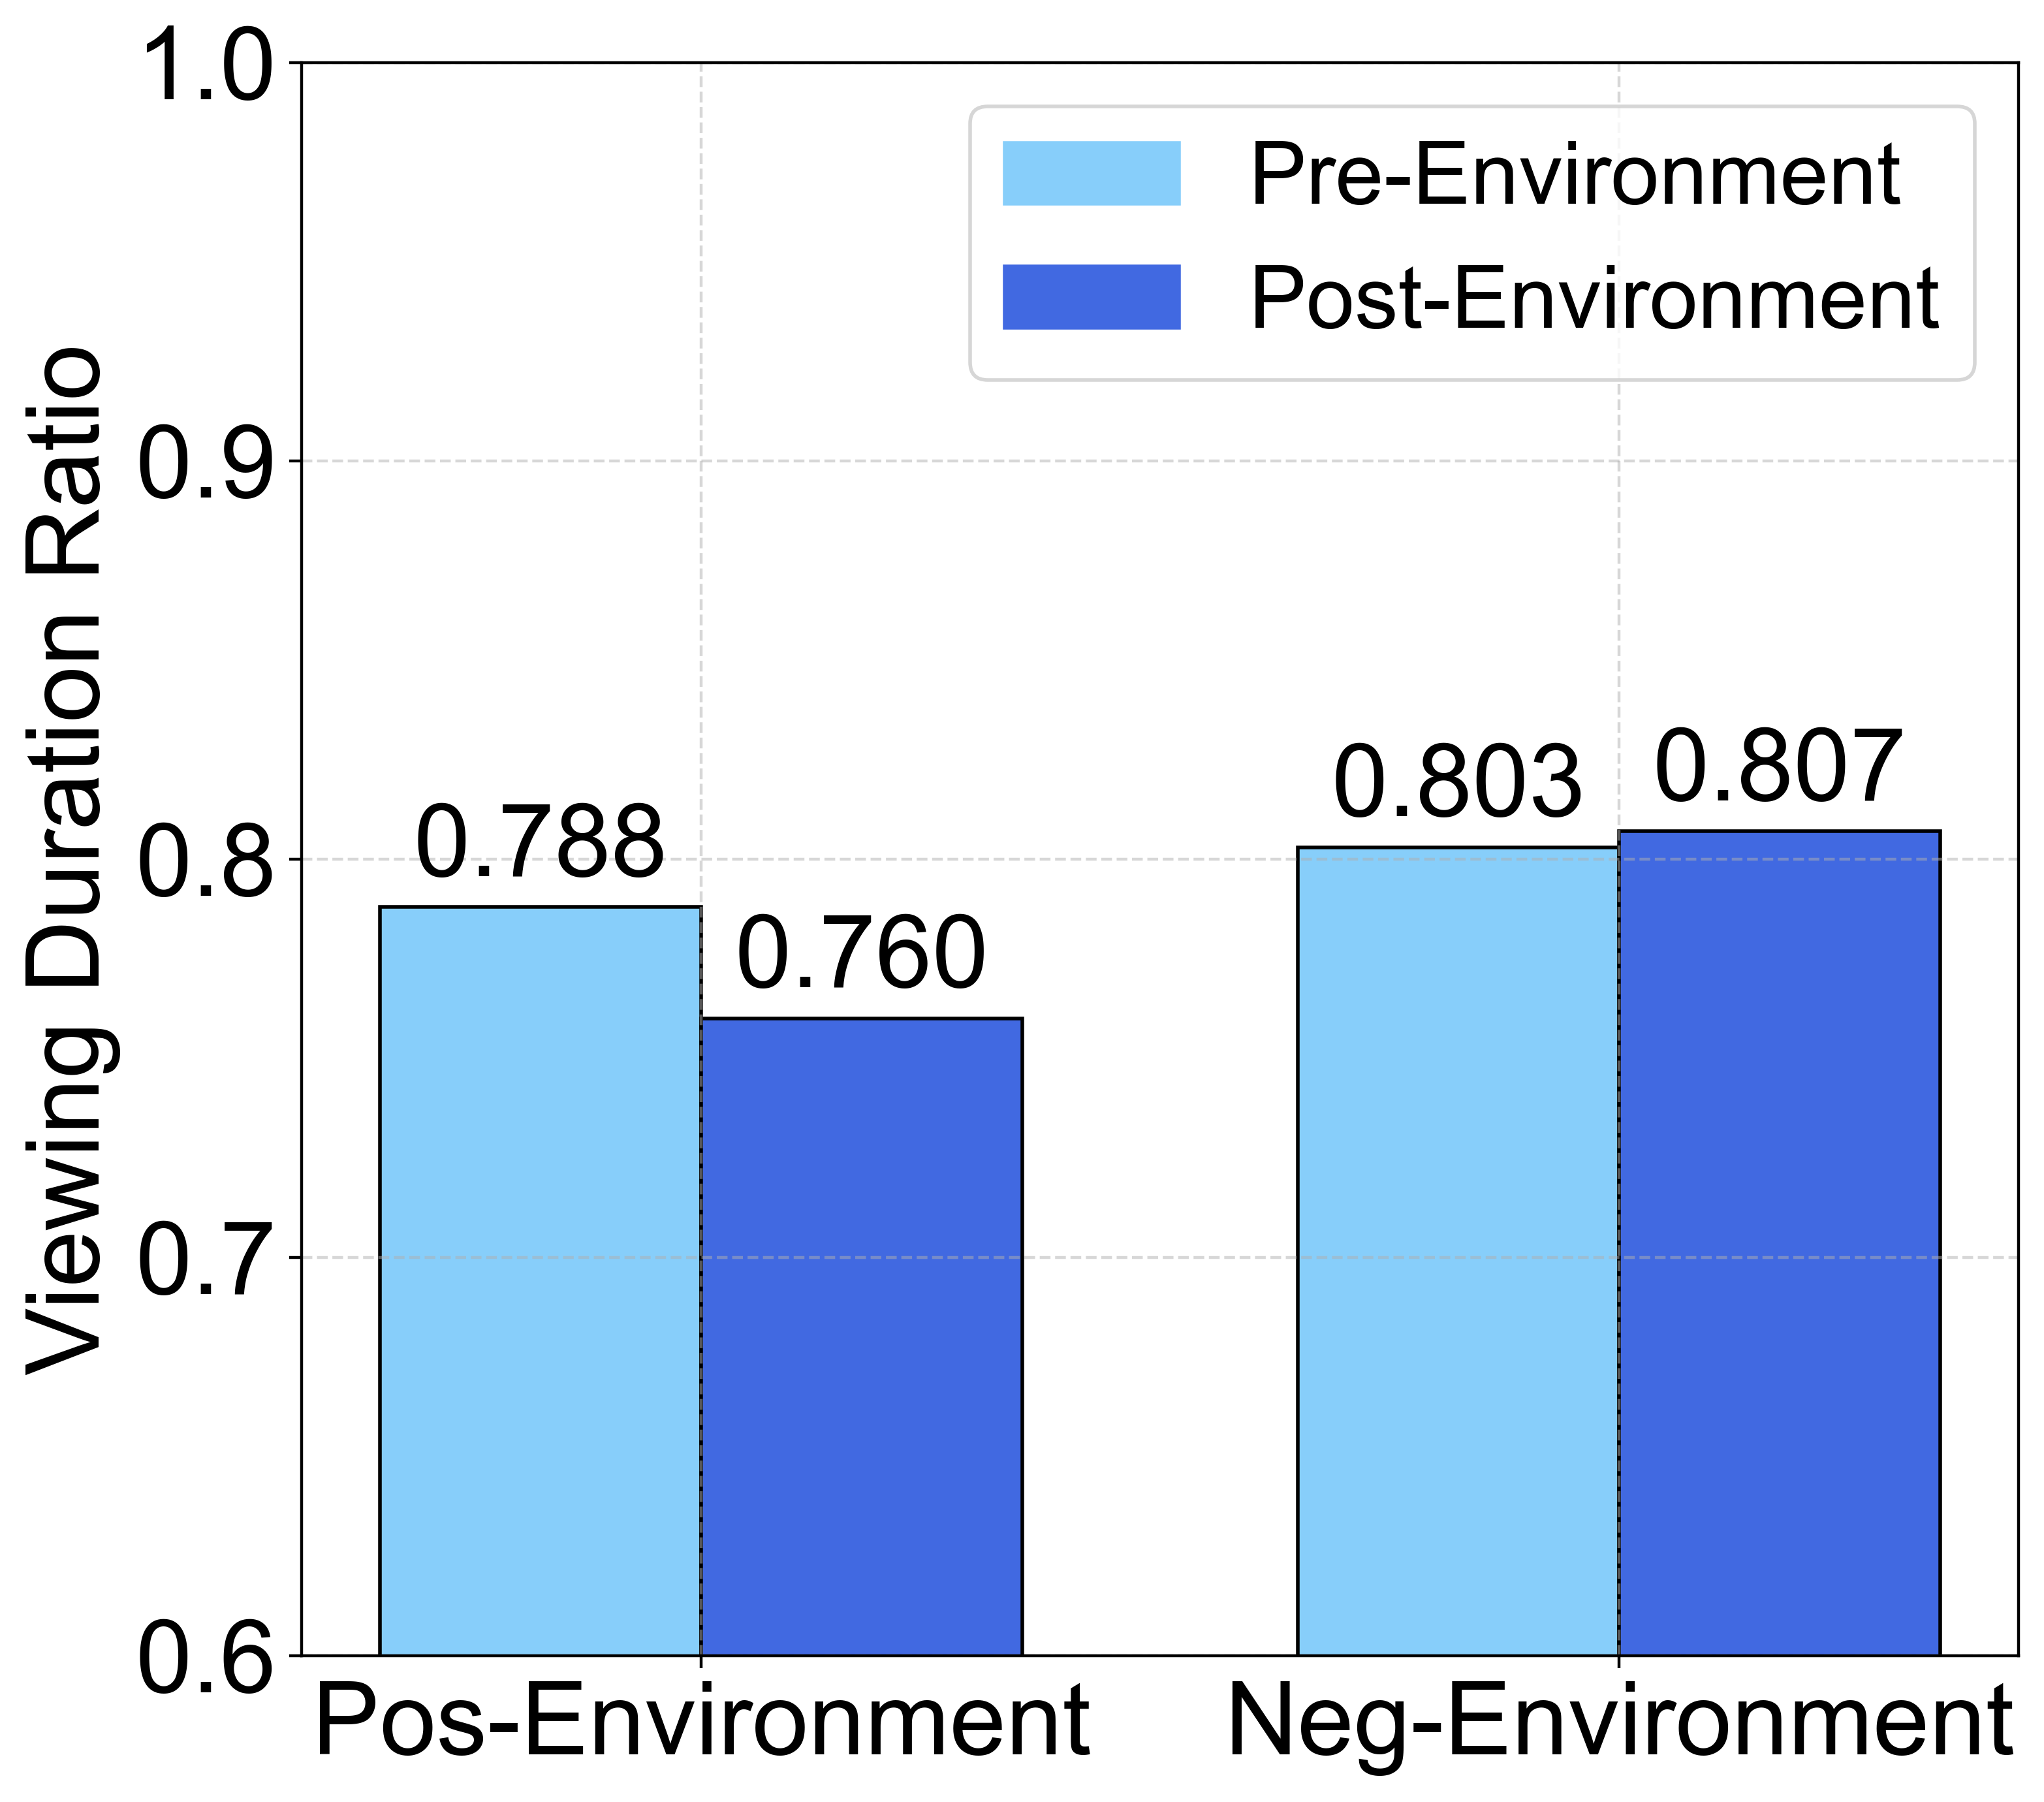

In [13]:
import matplotlib.patches as mpatches
# 新的数据
distractor_scores_new = (0.788, 0.760, 0.803, 0.807)

# 创建图表，保持与之前相同的高度
fig, ax = plt.subplots(figsize=(8, 7), dpi=400)

# 设置标签和宽度
labels = ['Pos-Environment', 'Neg-Environment']
width = 0.35  # 柱状图的宽度

# 计算每组柱状图的位置
x = np.arange(len(labels))
x_distractor_before = x - width / 2
x_distractor_after = x + width / 2

# 定义颜色
colors_positive = ['lightskyblue', 'lightskyblue']
colors_negative = ['royalblue', 'royalblue']

# 显示网格并设置网格样式
ax.grid(True, linestyle='--', alpha=0.5)

# 绘制柱状图
rects1 = ax.bar(x_distractor_before, distractor_scores_new[::2], width, color=colors_positive,edgecolor='black')
rects2 = ax.bar(x_distractor_after, distractor_scores_new[1::2], width, color=colors_negative,edgecolor='black')

# 在每个柱状图上添加数值
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=28)

# 增加坐标轴数字的字体大小
ax.tick_params(axis='both', which='major', labelsize=28)    
# 添加标签、标题和自定义x轴刻度标签
ax.set_ylabel('Viewing Duration Ratio', fontsize=28)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=28)

# 设置y轴的起始点为3
ax.set_ylim([0.6, 1])

# 创建自定义图例
legend_elements = [mpatches.Patch(color='lightskyblue', label='Pre-Environment'),
                   mpatches.Patch(color='royalblue', label='Post-Environment')]

# 将图例固定在右上角，并设置字体大小
ax.legend(handles=legend_elements, loc='upper right', fontsize=24)

# 调整布局
fig.tight_layout()

plt.savefig('./final_pics/time_for_positive_videos.png', dpi=300)
plt.show()

In [14]:
#正向/负向环境作用前后，观看负面视频的时长
time_nevideo_before_positive=[]
time_nevideo_after_positive=[]
time_nevideo_before_negative=[]
time_nevideo_after_negative=[]
for date in dates:
    for v,info in v2info_LAB1_data[date].items():
        if(info['video_type']==1):
            if(info['tend']==0):
                time_nevideo_before_positive.append(info['play_duration'])
            if(info['tend']==1):
                time_nevideo_before_negative.append(info['play_duration'])
    for v,info in v2info_LAB2_data[date].items():
        if(info['video_type']==1):
            if(info['tend']==0):
                time_nevideo_after_positive.append(info['play_duration'])
            if(info['tend']==1):
                time_nevideo_after_negative.append(info['play_duration'])
print("正向环境作用前，观看负面视频的平均时长：",np.mean(time_nevideo_before_positive))
print("正向环境作用后，观看负面视频的平均时长：",np.mean(time_nevideo_after_positive))
print("负向环境作用前，观看负面视频的平均时长：",np.mean(time_nevideo_before_negative))
print("负向环境作用后，观看负面视频的平均时长：",np.mean(time_nevideo_after_negative))    

正向环境作用前，观看负面视频的平均时长： 0.8137254901960784
正向环境作用后，观看负面视频的平均时长： 0.7669934640522876
负向环境作用前，观看负面视频的平均时长： 0.8228346456692914
负向环境作用后，观看负面视频的平均时长： 0.8016927083333334


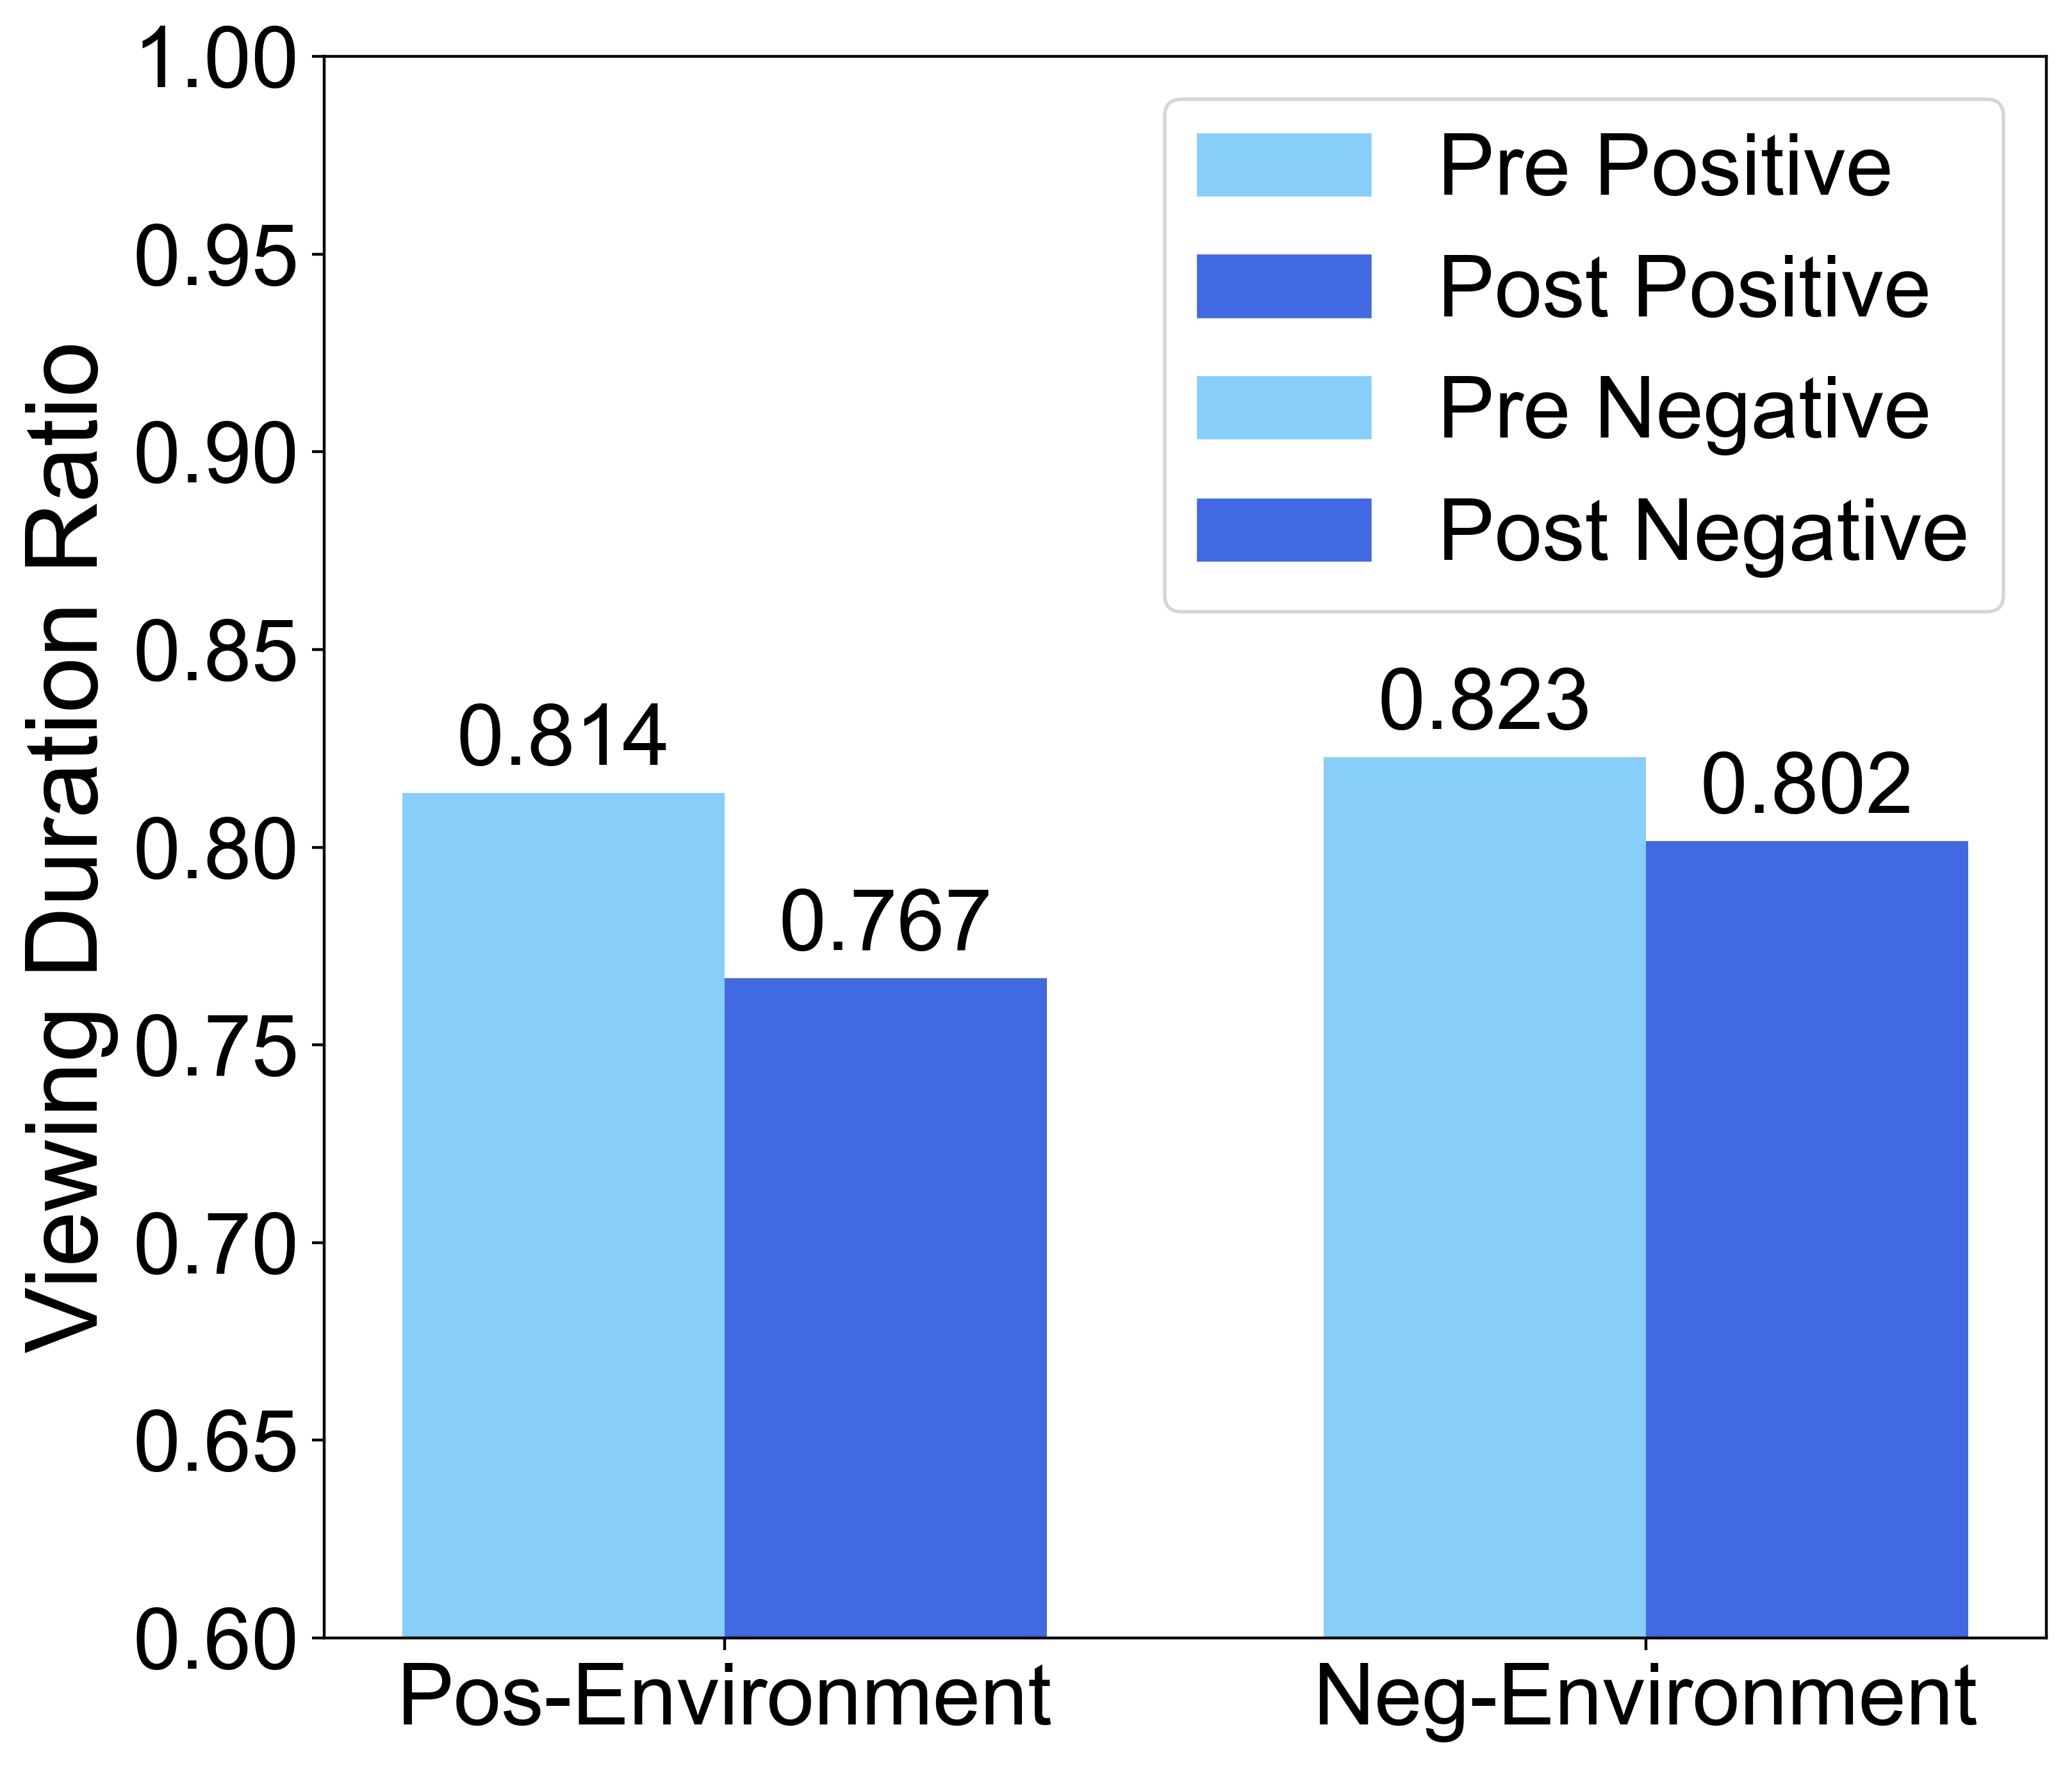

In [7]:
import matplotlib.patches as mpatches
# 新的数据
distractor_scores_new = (0.8137,0.7669,0.8228,0.8016)
# 创建图表，保持与之前相同的高度
fig, ax = plt.subplots(figsize=(8, 7), dpi=400)
# 设置标签和宽度
labels = ['Pos-Environment', 'Neg-Environment']
width = 0.35  # 柱状图的宽度
# 计算每组柱状图的位置
x = np.arange(len(labels))
x_distractor_before = x - width / 2
x_distractor_after = x + width / 2
# 定义颜色
colors_positive = ['lightskyblue', 'lightskyblue']
colors_negative = ['royalblue', 'royalblue']
# 绘制柱状图
rects1 = ax.bar(x_distractor_before, distractor_scores_new[::2], width, color=colors_positive)
rects2 = ax.bar(x_distractor_after, distractor_scores_new[1::2], width, color=colors_negative)
# 在每个柱状图上添加数值
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=24)
# 增加坐标轴数字的字体大小
ax.tick_params(axis='both', which='major', labelsize=24)    
# 添加标签、标题和自定义x轴刻度标签
ax.set_ylabel('Viewing Duration Ratio', fontsize=28)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=24)
# 设置y轴的起始点为3
ax.set_ylim([0.6, 1])
# 创建自定义图例
legend_elements = [mpatches.Patch(color='lightskyblue', label='Pre Positive'),
                   mpatches.Patch(color='royalblue', label='Post Positive'),
                   mpatches.Patch(color='lightskyblue', label='Pre Negative'),
                   mpatches.Patch(color='royalblue', label='Post Negative')]

# 将图例固定在右上角，并设置字体大小
ax.legend(handles=legend_elements, loc='upper right', fontsize=24)
# 调整布局
fig.tight_layout()
# 显示图表
plt.savefig('./final_pics/time_for_negative_videos.png', dpi=300)
plt.show()

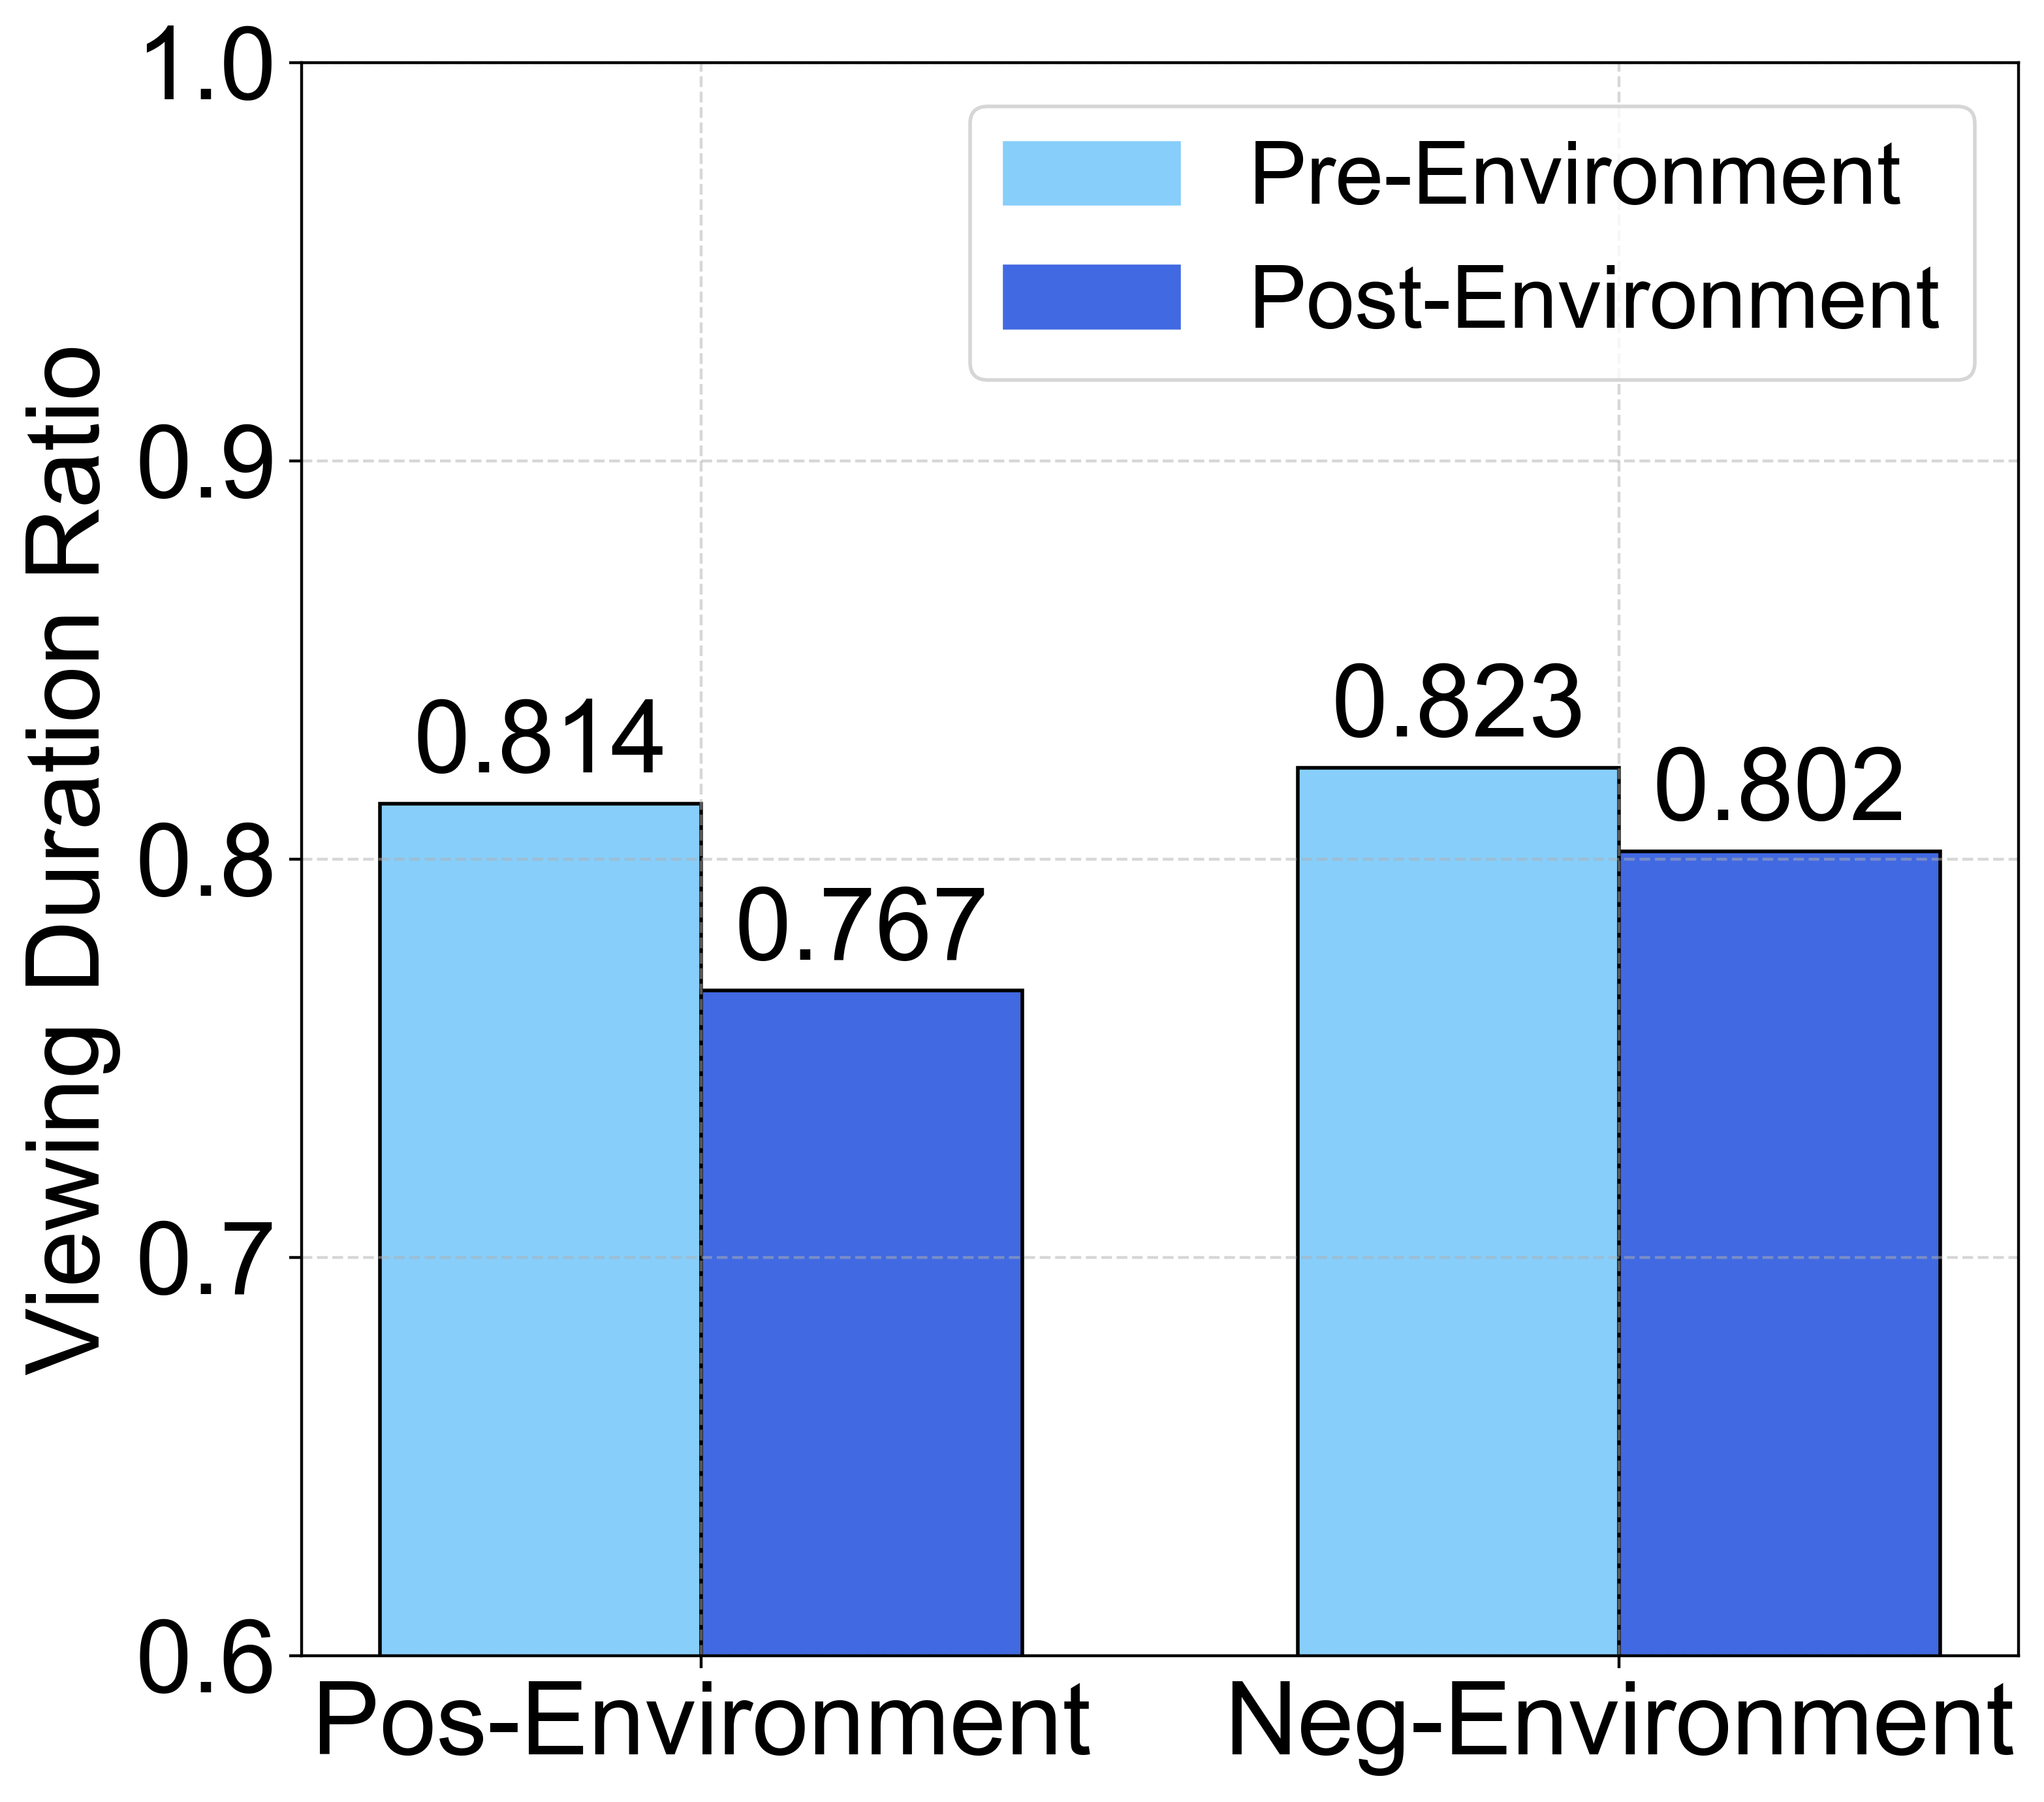

In [12]:
import matplotlib.patches as mpatches
# 新的数据
distractor_scores_new = (0.814, 0.767, 0.823, 0.802)

# 创建图表，保持与之前相同的高度
fig, ax = plt.subplots(figsize=(8, 7), dpi=400)

# 设置标签和宽度
labels = ['Pos-Environment', 'Neg-Environment']
width = 0.35  # 柱状图的宽度

# 计算每组柱状图的位置
x = np.arange(len(labels))
x_distractor_before = x - width / 2
x_distractor_after = x + width / 2

# 定义颜色
colors_positive = ['lightskyblue', 'lightskyblue']
colors_negative = ['royalblue', 'royalblue']

# 显示网格并设置网格样式
ax.grid(True, linestyle='--', alpha=0.5)

# 绘制柱状图
rects1 = ax.bar(x_distractor_before, distractor_scores_new[::2], width, color=colors_positive,edgecolor='black')
rects2 = ax.bar(x_distractor_after, distractor_scores_new[1::2], width, color=colors_negative,edgecolor='black')

# 在每个柱状图上添加数值
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=28)

# 增加坐标轴数字的字体大小
ax.tick_params(axis='both', which='major', labelsize=28)    
# 添加标签、标题和自定义x轴刻度标签
ax.set_ylabel('Viewing Duration Ratio', fontsize=28)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=28)

# 设置y轴的起始点为3
ax.set_ylim([0.6, 1])

# 创建自定义图例
legend_elements = [mpatches.Patch(color='lightskyblue', label='Pre-Environment'),
                   mpatches.Patch(color='royalblue', label='Post-Environment')]

# 将图例固定在右上角，并设置字体大小
ax.legend(handles=legend_elements, loc='upper right', fontsize=24)

# 调整布局
fig.tight_layout()

plt.savefig('./final_pics/time_for_negative_videos.png', dpi=300)
plt.show()

In [8]:
#标准化！
#正向/负向环境作用前后，观看负面视频的时长
time_nevideo_before_positive=[]
time_nevideo_after_positive=[]
time_nevideo_before_negative=[]
time_nevideo_after_negative=[]
for date in dates:
    time_mean,time_std=time_core[date]
    for v,info in v2info_LAB1_data[date].items():
        if(info['video_type']==1):
            if(info['tend']==0):
                time_nevideo_before_positive.append((info['play_duration']-time_mean)/time_std)
            if(info['tend']==1):
                time_nevideo_before_negative.append((info['play_duration']-time_mean)/time_std)
    for v,info in v2info_LAB2_data[date].items():
        if(info['video_type']==1):
            if(info['tend']==0):
                time_nevideo_after_positive.append((info['play_duration']-time_mean)/time_std)
            if(info['tend']==1):
                time_nevideo_after_negative.append((info['play_duration']-time_mean)/time_std)
    

print("正向环境作用前，观看负面视频的平均时长：",np.mean(time_nevideo_before_positive))
print("正向环境作用后，观看负面视频的平均时长：",np.mean(time_nevideo_after_positive))
print("负向环境作用前，观看负面视频的平均时长：",np.mean(time_nevideo_before_negative))
print("负向环境作用后，观看负面视频的平均时长：",np.mean(time_nevideo_after_negative))    

正向环境作用前，观看负面视频的平均时长： 0.08187656348775685
正向环境作用后，观看负面视频的平均时长： -0.15094821456847893
负向环境作用前，观看负面视频的平均时长： 0.023707502570803368
负向环境作用后，观看负面视频的平均时长： -0.14785605638362262


In [9]:
#正向/负向环境作用前后，观看正面视频的点赞率
like_povideo_before_positive=[]
like_povideo_after_positive=[]
like_povideo_before_negative=[]
like_povideo_after_negative=[]
for date in dates:
    like_mean,like_std=like_core[date]
    for v,info in v2info_LAB1_data[date].items():
        if(info['video_type']==0):
            if(info['tend']==0):
                like_povideo_before_positive.append(info['like'])
            if(info['tend']==1):
                like_povideo_before_negative.append(info['like'])
    for v,info in v2info_LAB2_data[date].items():
        if(info['video_type']==0):
            if(info['tend']==0):
                like_povideo_after_positive.append(info['like'])
            if(info['tend']==1):
                like_povideo_after_negative.append(info['like'])
print("正向环境作用前，观看正面视频的点赞率：",np.mean(like_povideo_before_positive))
print("正向环境作用后，观看正面视频的点赞率：",np.mean(like_povideo_after_positive))
print("负向环境作用前，观看正面视频的点赞率：",np.mean(like_povideo_before_negative))
print("负向环境作用后，观看正面视频的点赞率：",np.mean(like_povideo_after_negative))        

正向环境作用前，观看正面视频的点赞率： 0.16666666666666666
正向环境作用后，观看正面视频的点赞率： 0.10784313725490197
负向环境作用前，观看正面视频的点赞率： 0.140625
负向环境作用后，观看正面视频的点赞率： 0.078125


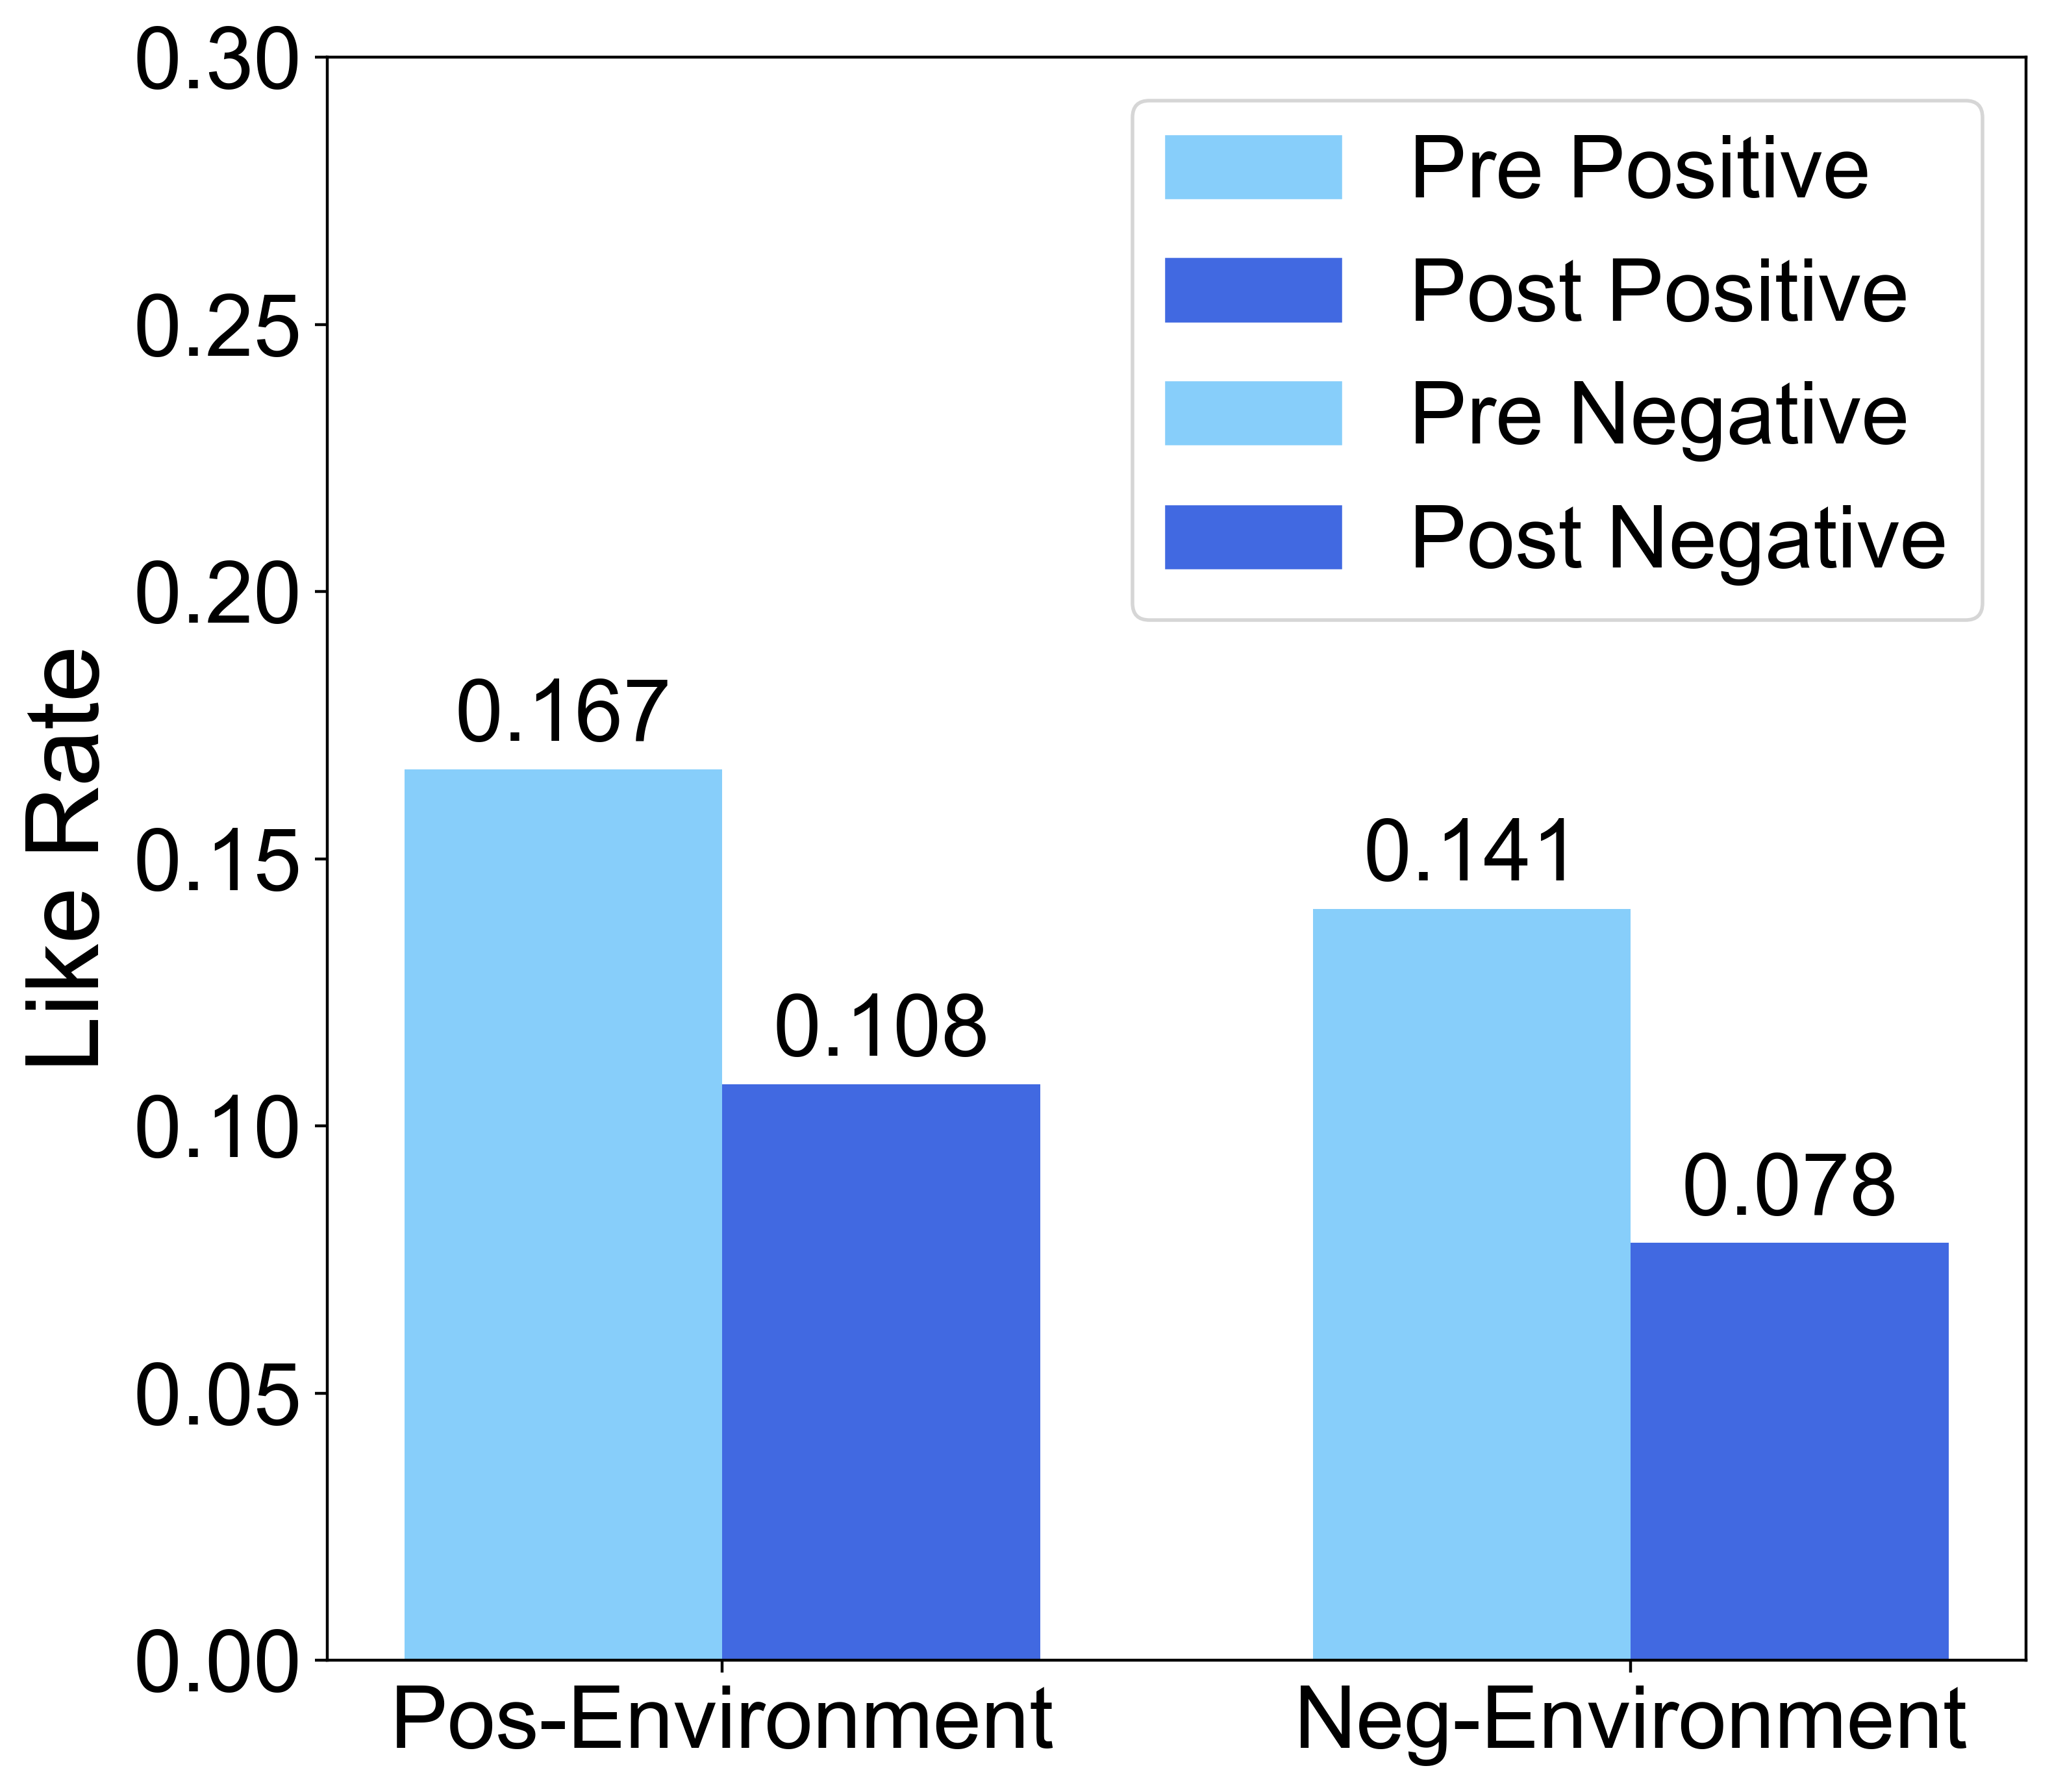

In [11]:
import matplotlib.patches as mpatches
# 新的数据
distractor_scores_new = (0.1667,0.1078,0.1406,0.0781)
# 创建图表，保持与之前相同的高度
fig, ax = plt.subplots(figsize=(8, 7), dpi=400)
# 设置标签和宽度
labels = ['Pos-Environment', 'Neg-Environment']
width = 0.35  # 柱状图的宽度
# 计算每组柱状图的位置
x = np.arange(len(labels))
x_distractor_before = x - width / 2
x_distractor_after = x + width / 2
# 定义颜色
colors_positive = ['lightskyblue', 'lightskyblue']
colors_negative = ['royalblue', 'royalblue']
# 绘制柱状图
rects1 = ax.bar(x_distractor_before, distractor_scores_new[::2], width, color=colors_positive)
rects2 = ax.bar(x_distractor_after, distractor_scores_new[1::2], width, color=colors_negative)
# 在每个柱状图上添加数值
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=24)
# 增加坐标轴数字的字体大小
ax.tick_params(axis='both', which='major', labelsize=24)    
# 添加标签、标题和自定义x轴刻度标签
ax.set_ylabel('Like Rate', fontsize=28)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=24)
# 设置y轴的起始点为3
ax.set_ylim([0, 0.3])
# 创建自定义图例
legend_elements = [mpatches.Patch(color='lightskyblue', label='Pre Positive'),
                   mpatches.Patch(color='royalblue', label='Post Positive'),
                   mpatches.Patch(color='lightskyblue', label='Pre Negative'),
                   mpatches.Patch(color='royalblue', label='Post Negative')]

# 将图例固定在右上角，并设置字体大小
ax.legend(handles=legend_elements, loc='upper right', fontsize=24)
# 调整布局
fig.tight_layout()
# 显示图表
plt.savefig('./final_pics/like_for_positive_videos.png', dpi=300)
plt.show()

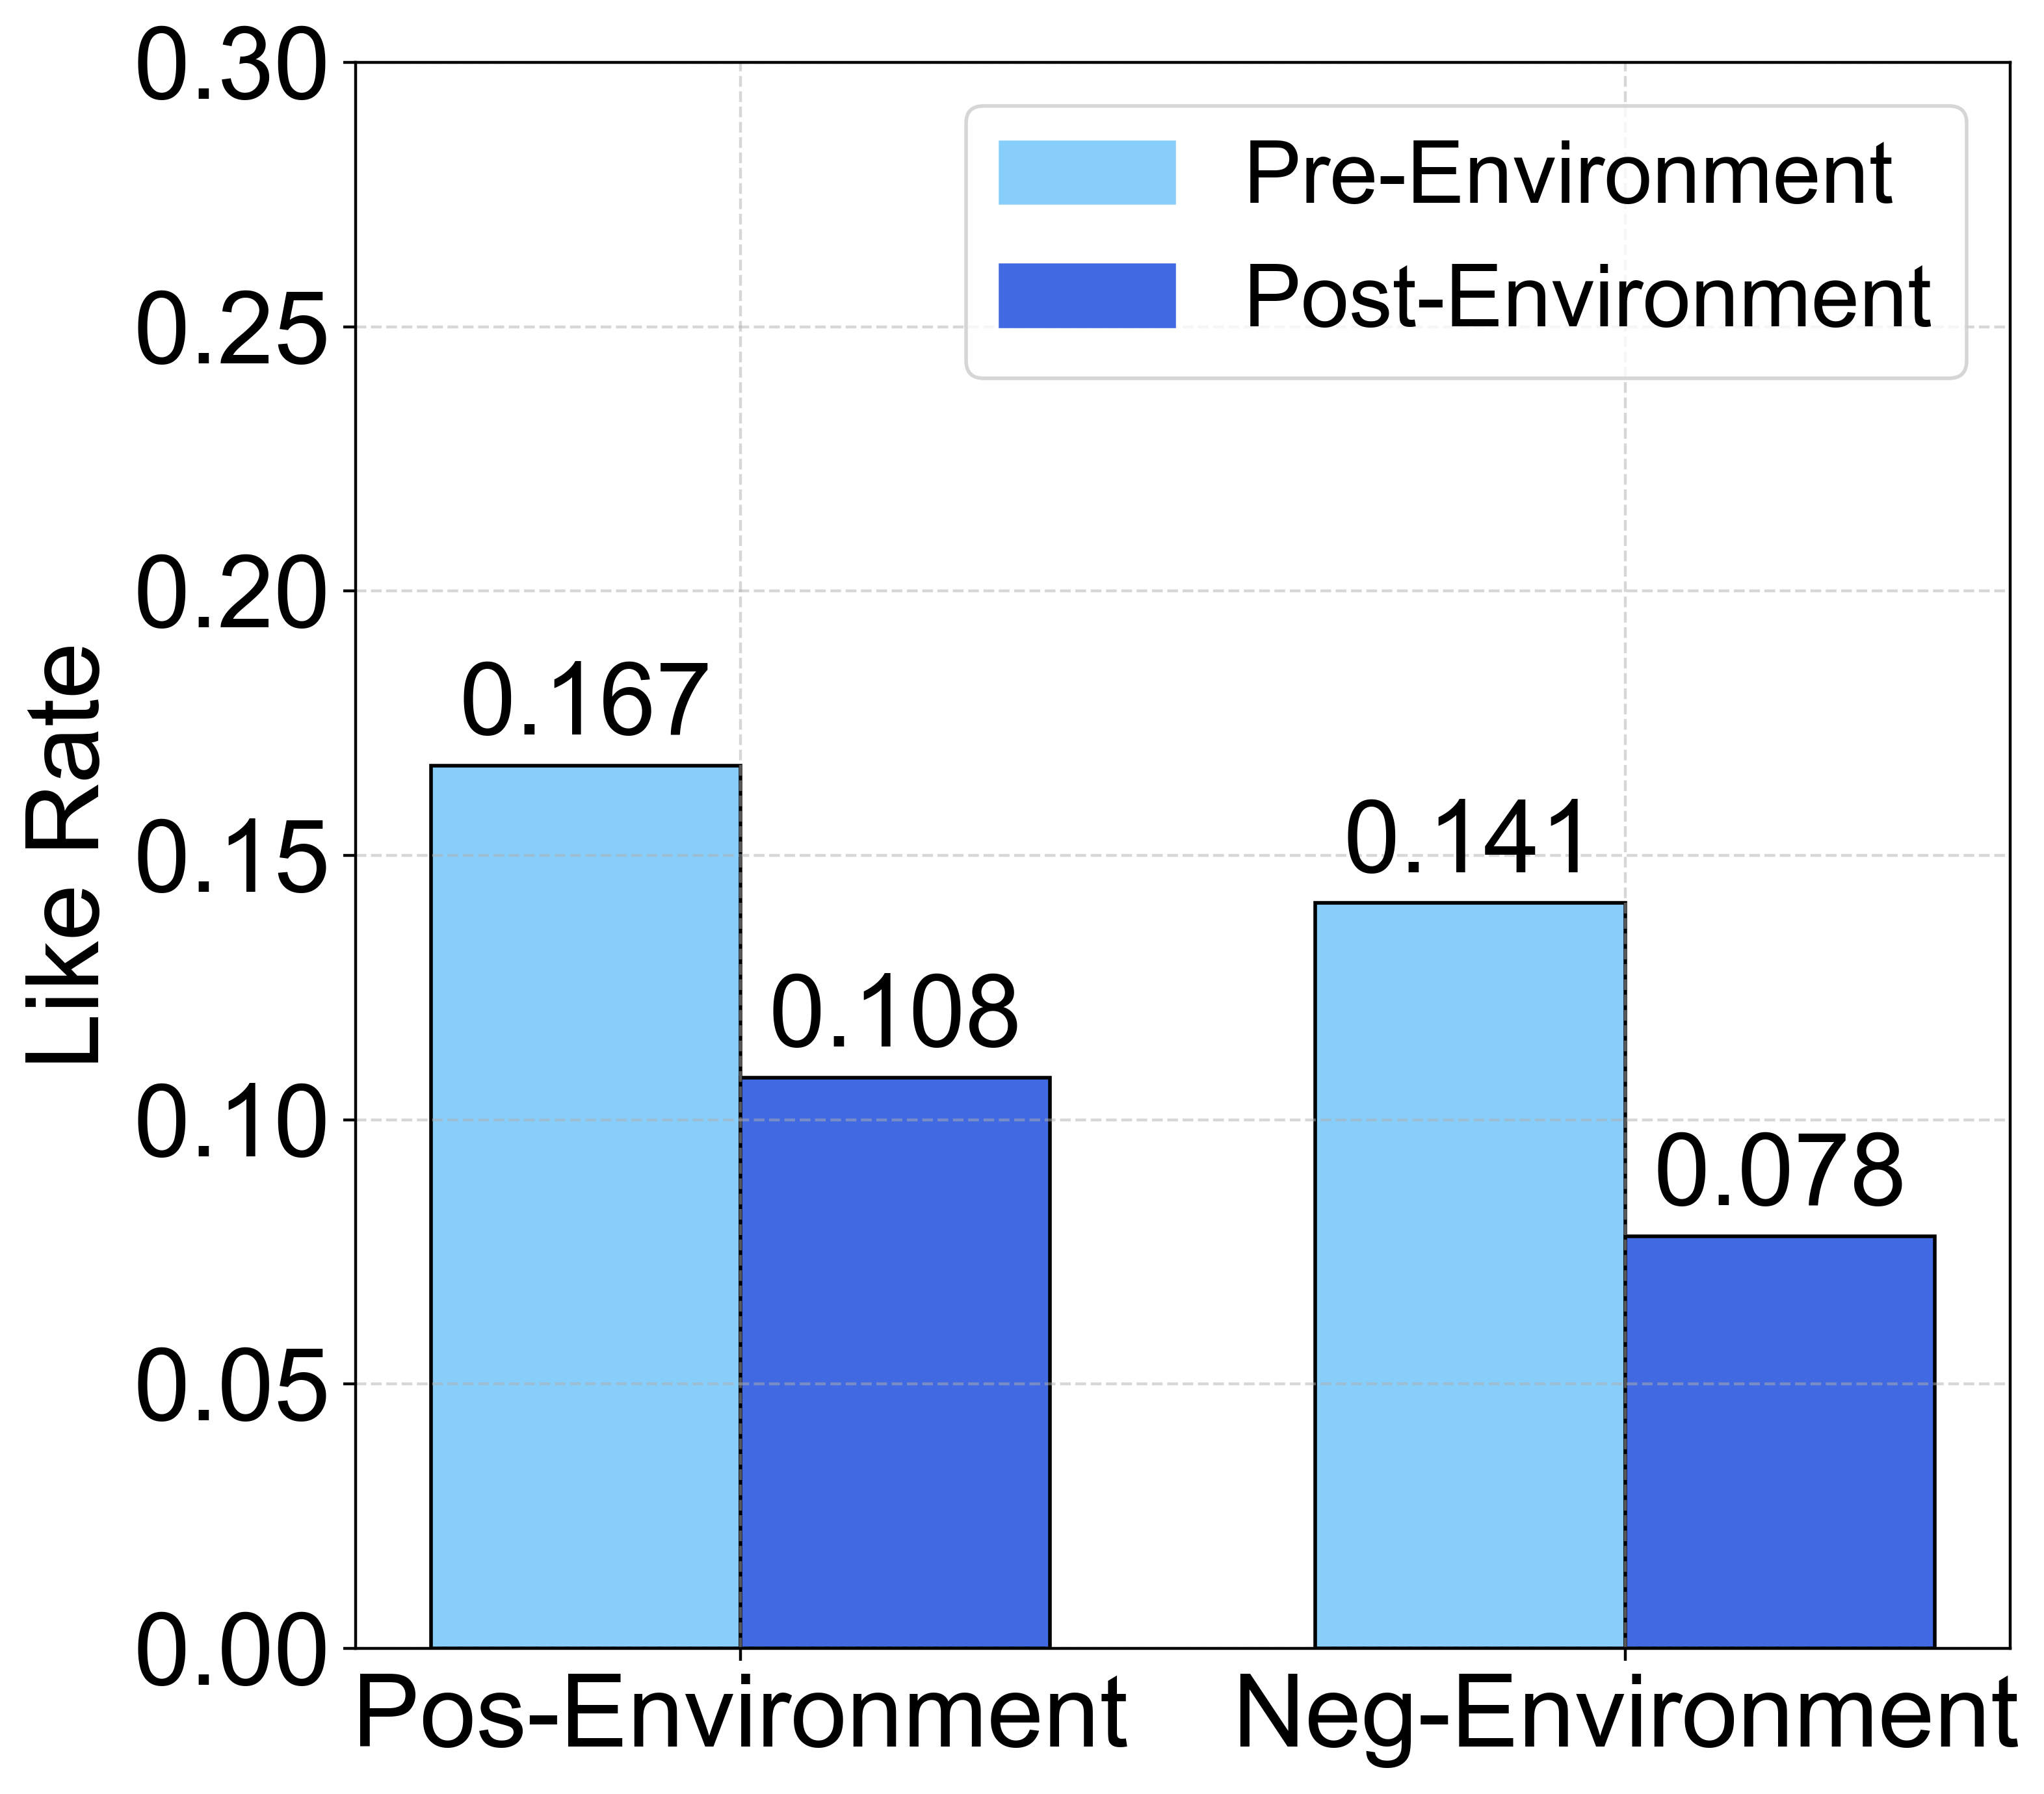

In [15]:
import matplotlib.patches as mpatches
# 新的数据
distractor_scores_new = (0.167, 0.108, 0.141, 0.078)

# 创建图表，保持与之前相同的高度
fig, ax = plt.subplots(figsize=(8, 7), dpi=400)

# 设置标签和宽度
labels = ['Pos-Environment', 'Neg-Environment']
width = 0.35  # 柱状图的宽度

# 计算每组柱状图的位置
x = np.arange(len(labels))
x_distractor_before = x - width / 2
x_distractor_after = x + width / 2

# 定义颜色
colors_positive = ['lightskyblue', 'lightskyblue']
colors_negative = ['royalblue', 'royalblue']

# 显示网格并设置网格样式
ax.grid(True, linestyle='--', alpha=0.5)

# 绘制柱状图
rects1 = ax.bar(x_distractor_before, distractor_scores_new[::2], width, color=colors_positive,edgecolor='black')
rects2 = ax.bar(x_distractor_after, distractor_scores_new[1::2], width, color=colors_negative,edgecolor='black')

# 在每个柱状图上添加数值
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=28)

# 增加坐标轴数字的字体大小
ax.tick_params(axis='both', which='major', labelsize=28)    
# 添加标签、标题和自定义x轴刻度标签
ax.set_ylabel('Like Rate', fontsize=28)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=28)

# 设置y轴的起始点为3
ax.set_ylim([0, 0.3])

# 创建自定义图例
legend_elements = [mpatches.Patch(color='lightskyblue', label='Pre-Environment'),
                   mpatches.Patch(color='royalblue', label='Post-Environment')]

# 将图例固定在右上角，并设置字体大小
ax.legend(handles=legend_elements, loc='upper right', fontsize=24)

# 调整布局
fig.tight_layout()

plt.savefig('./final_pics/like_for_positive_videos.png', dpi=300)
plt.show()

In [16]:
#正向/负向环境作用前后，观看负面视频的点赞率
like_nevideo_before_positive=[]
like_nevideo_after_positive=[]
like_nevideo_before_negative=[]
like_nevideo_after_negative=[]
for date in dates:
    for v,info in v2info_LAB1_data[date].items():
        if(info['video_type']==1):
            if(info['tend']==0):
                like_nevideo_before_positive.append(info['like'])
            if(info['tend']==1):
                like_nevideo_before_negative.append(info['like'])
    for v,info in v2info_LAB2_data[date].items():
        if(info['video_type']==1):
            if(info['tend']==0):
                like_nevideo_after_positive.append(info['like'])
            if(info['tend']==1):
                like_nevideo_after_negative.append(info['like'])
print("正向环境作用前，观看负面视频的点赞率：",np.mean(like_nevideo_before_positive))
print("正向环境作用后，观看负面视频的点赞率：",np.mean(like_nevideo_after_positive))
print("负向环境作用前，观看负面视频的点赞率：",np.mean(like_nevideo_before_negative))
print("负向环境作用后，观看负面视频的点赞率：",np.mean(like_nevideo_after_negative))        

正向环境作用前，观看负面视频的点赞率： 0.1568627450980392
正向环境作用后，观看负面视频的点赞率： 0.0784313725490196
负向环境作用前，观看负面视频的点赞率： 0.12598425196850394
负向环境作用后，观看负面视频的点赞率： 0.046875


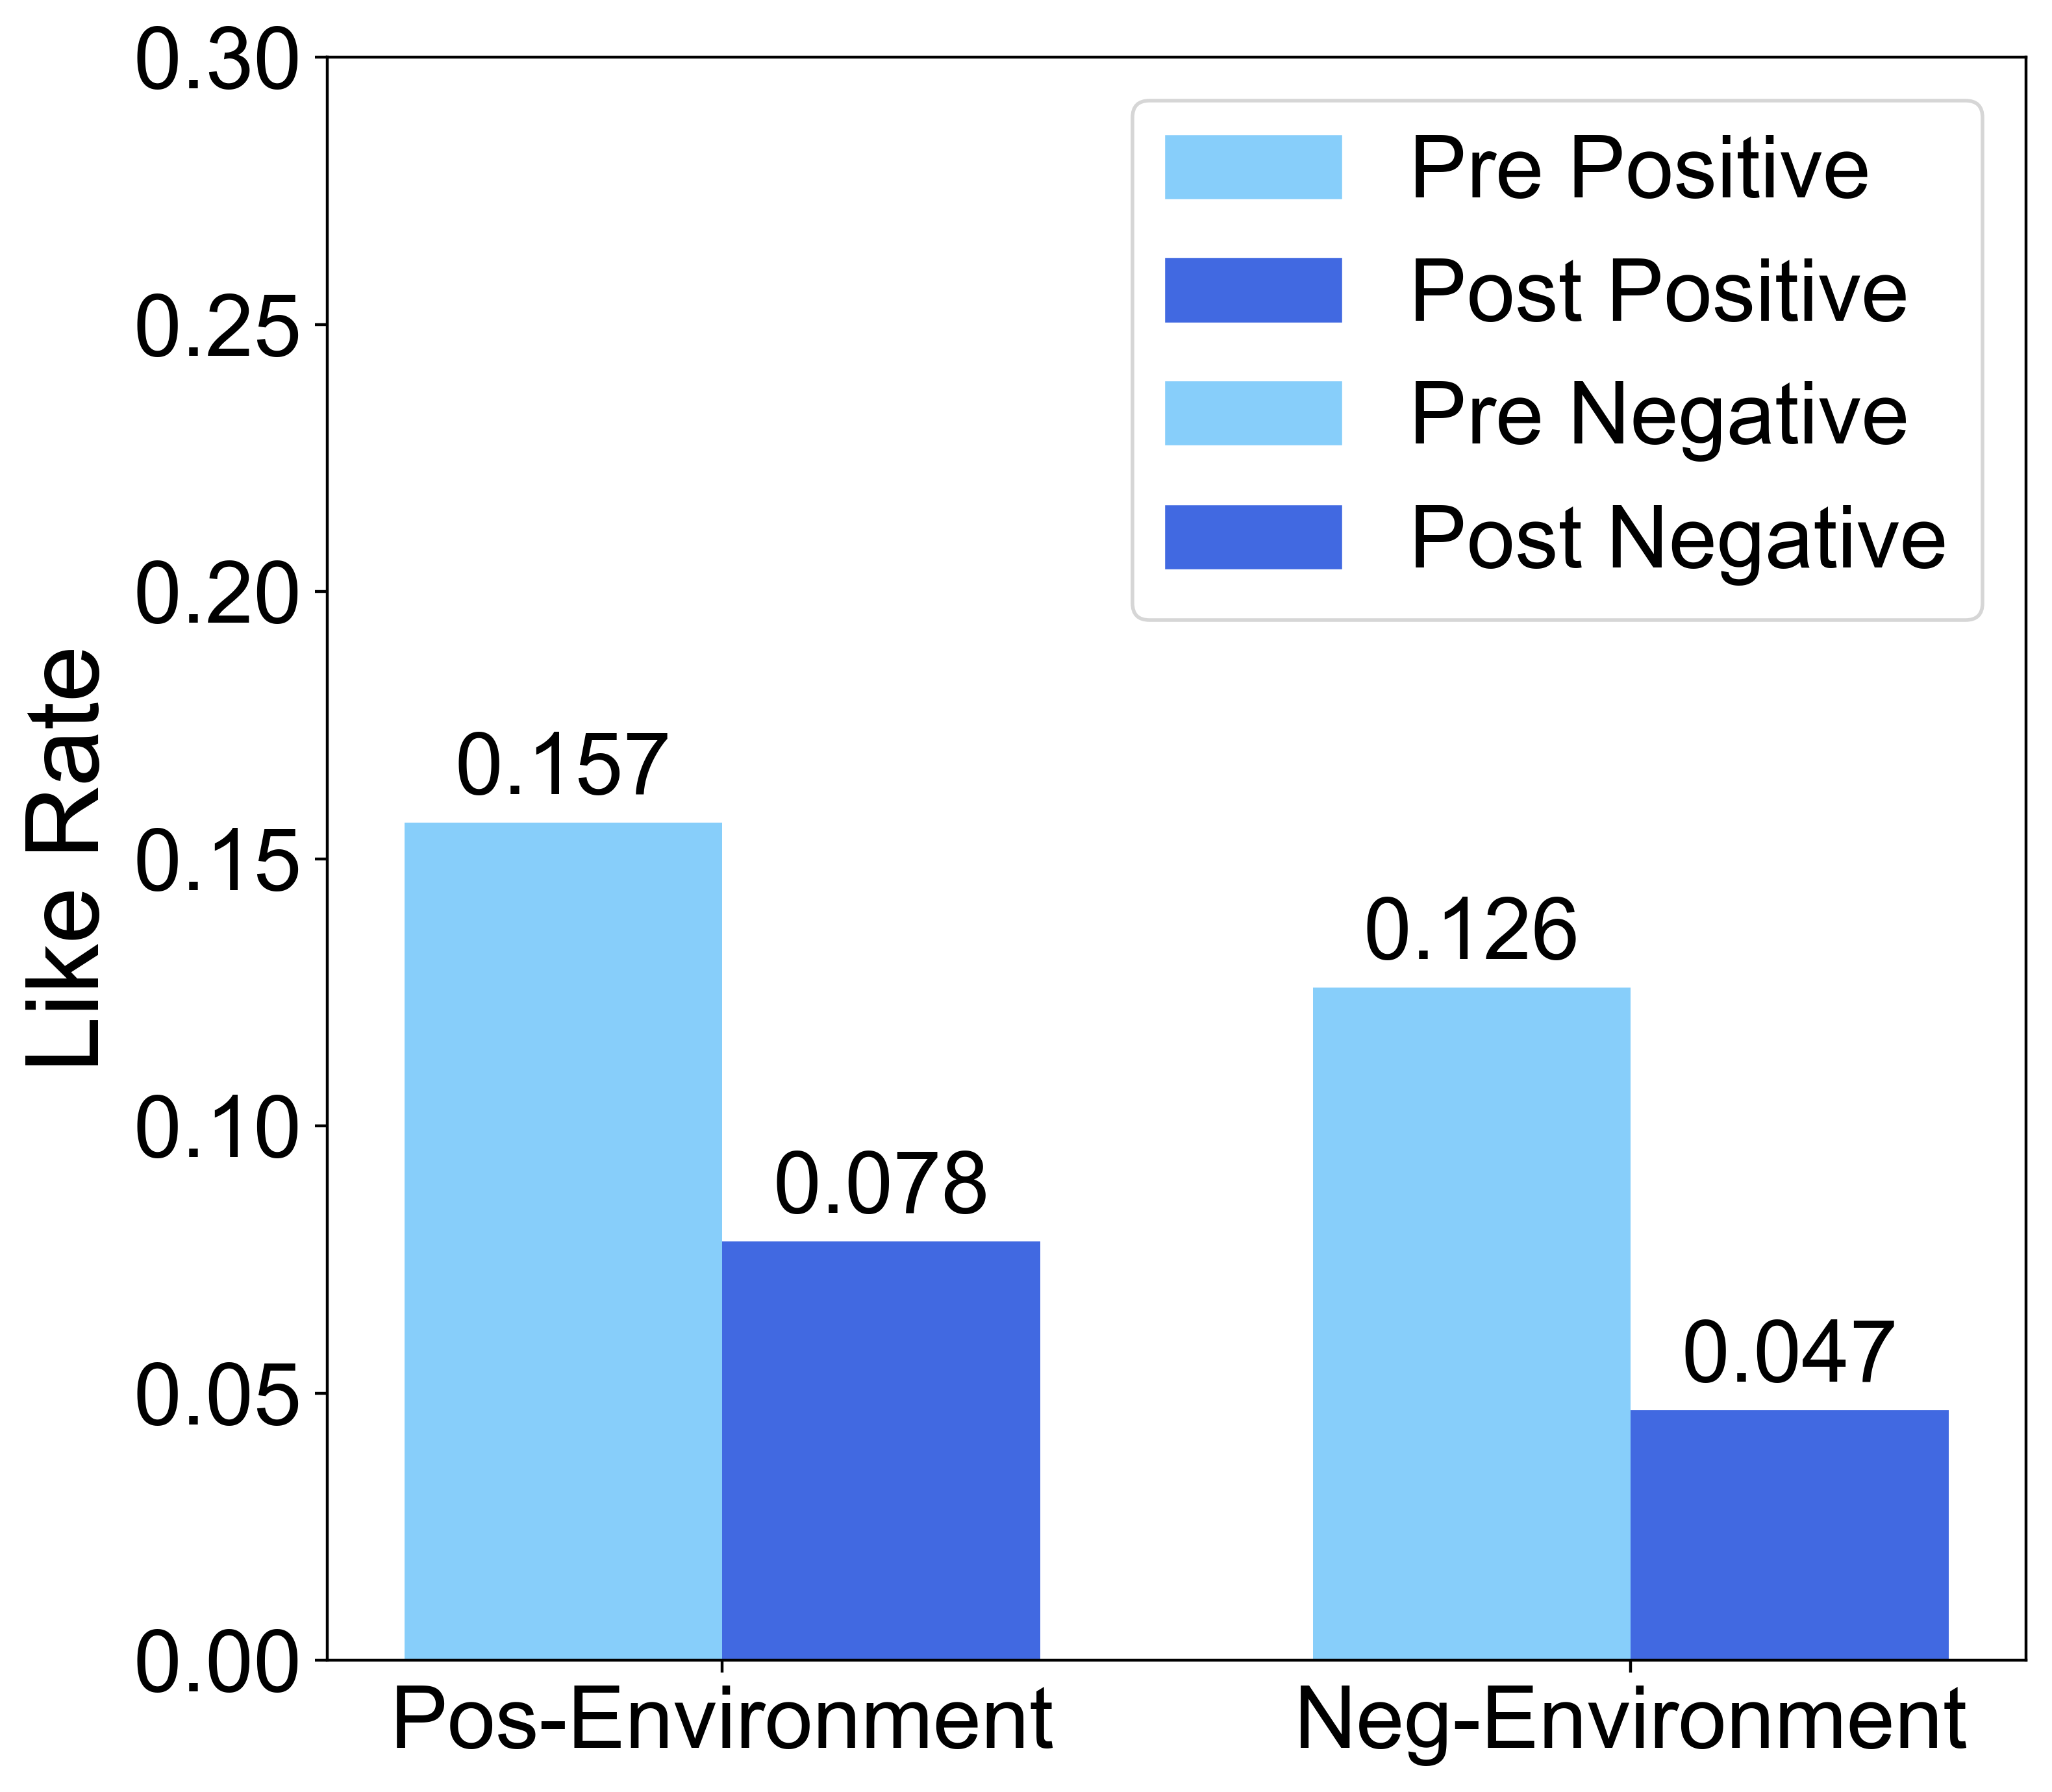

In [12]:
import matplotlib.patches as mpatches
# 新的数据
distractor_scores_new = (0.1568,0.0784,0.1259,0.0468)
# 创建图表，保持与之前相同的高度
fig, ax = plt.subplots(figsize=(8, 7), dpi=400)
# 设置标签和宽度
labels = ['Pos-Environment', 'Neg-Environment']
width = 0.35  # 柱状图的宽度
# 计算每组柱状图的位置
x = np.arange(len(labels))
x_distractor_before = x - width / 2
x_distractor_after = x + width / 2
# 定义颜色
colors_positive = ['lightskyblue', 'lightskyblue']
colors_negative = ['royalblue', 'royalblue']
# 绘制柱状图
rects1 = ax.bar(x_distractor_before, distractor_scores_new[::2], width, color=colors_positive)
rects2 = ax.bar(x_distractor_after, distractor_scores_new[1::2], width, color=colors_negative)
# 在每个柱状图上添加数值
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=24)
# 增加坐标轴数字的字体大小
ax.tick_params(axis='both', which='major', labelsize=24)    
# 添加标签、标题和自定义x轴刻度标签
ax.set_ylabel('Like Rate', fontsize=28)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=24)
# 设置y轴的起始点为3
ax.set_ylim([0, 0.3])
# 创建自定义图例
legend_elements = [mpatches.Patch(color='lightskyblue', label='Pre Positive'),
                   mpatches.Patch(color='royalblue', label='Post Positive'),
                   mpatches.Patch(color='lightskyblue', label='Pre Negative'),
                   mpatches.Patch(color='royalblue', label='Post Negative')]

# 将图例固定在右上角，并设置字体大小
ax.legend(handles=legend_elements, loc='upper right', fontsize=24)
# 调整布局
fig.tight_layout()
# 显示图表
plt.savefig('./final_pics/like_for_negative_videos.png', dpi=300)
plt.show()

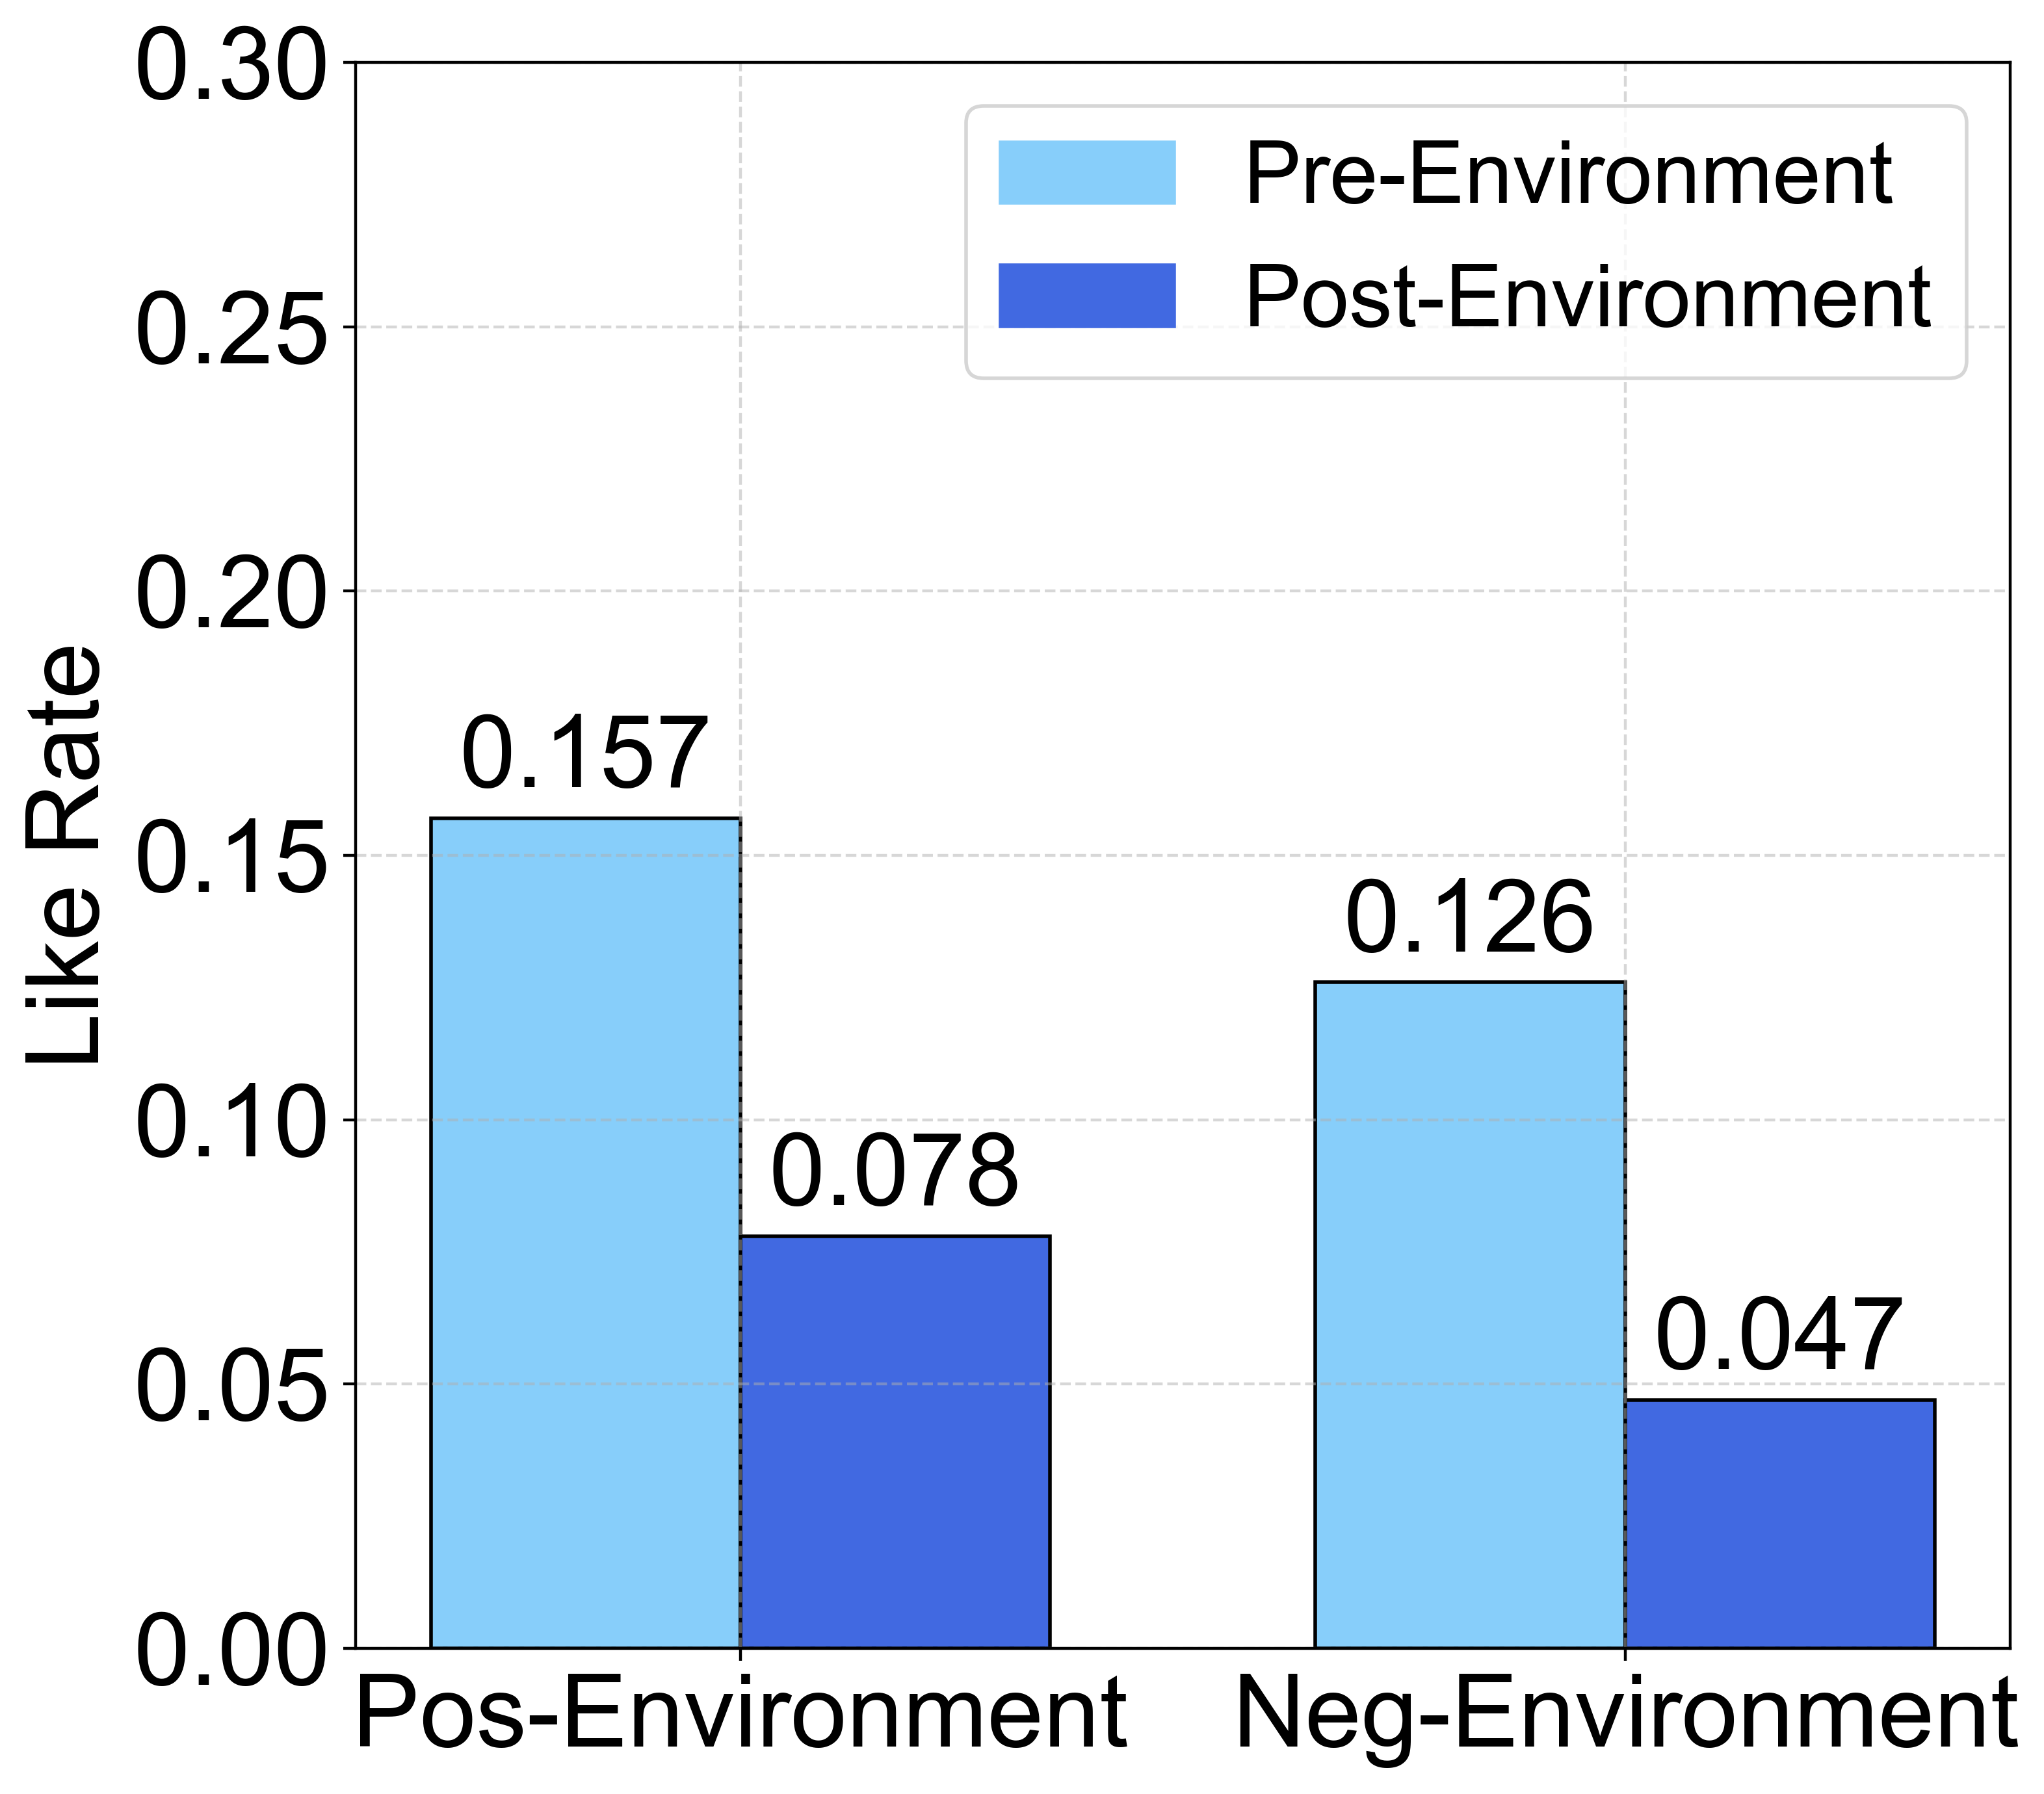

In [17]:
import matplotlib.patches as mpatches
# 新的数据
distractor_scores_new = (0.157, 0.078, 0.126, 0.047)

# 创建图表，保持与之前相同的高度
fig, ax = plt.subplots(figsize=(8, 7), dpi=400)

# 设置标签和宽度
labels = ['Pos-Environment', 'Neg-Environment']
width = 0.35  # 柱状图的宽度

# 计算每组柱状图的位置
x = np.arange(len(labels))
x_distractor_before = x - width / 2
x_distractor_after = x + width / 2

# 定义颜色
colors_positive = ['lightskyblue', 'lightskyblue']
colors_negative = ['royalblue', 'royalblue']

# 显示网格并设置网格样式
ax.grid(True, linestyle='--', alpha=0.5)

# 绘制柱状图
rects1 = ax.bar(x_distractor_before, distractor_scores_new[::2], width, color=colors_positive,edgecolor='black')
rects2 = ax.bar(x_distractor_after, distractor_scores_new[1::2], width, color=colors_negative,edgecolor='black')

# 在每个柱状图上添加数值
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=28)

# 增加坐标轴数字的字体大小
ax.tick_params(axis='both', which='major', labelsize=28)    
# 添加标签、标题和自定义x轴刻度标签
ax.set_ylabel('Like Rate', fontsize=28)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=28)

# 设置y轴的起始点为3
ax.set_ylim([0, 0.3])

# 创建自定义图例
legend_elements = [mpatches.Patch(color='lightskyblue', label='Pre-Environment'),
                   mpatches.Patch(color='royalblue', label='Post-Environment')]

# 将图例固定在右上角，并设置字体大小
ax.legend(handles=legend_elements, loc='upper right', fontsize=24)

# 调整布局
fig.tight_layout()

plt.savefig('./final_pics/like_for_negative_videos.png', dpi=300)
plt.show()